## Income Fluctuations Problem Model (IFP)

In [ ]:
#installing quantecon and interpolation
!pip install quantecon
!pip install interpolation

     |████████████████████████████████| 235kB 8.3MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
  Created wheel for tempita: filename=Tempita-0.5.2-cp37-none-any.whl size=12882 sha256=f62348b5b007200770f890f65ef589c6b95480d0a5afe4a32e6a75d1dd350cb6
  Stored in directory: /root/.cache/pip/wheels/1e/db/04/d827f417f162a149fbdfdd1d015c7769b393124aa98eb29642
Successfully built tempita


In [ ]:
#Importing libraries
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64, jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
from scipy.stats import entropy
import math
import pandas
import scipy.interpolate as intrp
from scipy.stats import norm
from collections import OrderedDict 
from collections import Counter
import matplotlib as mpl
import matplotlib.pylab as pl
import random
from collections import defaultdict
from google.colab import files

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
#Data validations
ifp_data = [
    ('γ', float64),              # utility parameter
    ('β', float64),              # discount factor
    ('P', float64[:, :]),        # transition probs for z_t
    ('P_t',float64[:,:]),
    ('P_p',float64[:,:]),
    ('P_n',float64[:,:]),
    ('a_r', float64),            # scale parameter for R_t
    ('b_r', float64),            # additive parameter for R_t
    ('a_y', float64),            # scale parameter for Y_t
    ('b_y', float64),            # additive parameter for Y_t
    ('s_grid', float64[:]),      # Grid over savings
    ('η_draws', float64[:]),     # Draws of innovation η for MC
     ('y', float64[:]),           # Income is Y_t = y[Z_t]
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC
]

In [ ]:
# Setting up the iterations and the display setup
iterations = 10
RoundsToDisplay = [0,1,3,5,7,9]
ColorCodes = [0,1,3,5,7,9]

In [ ]:
# Setting up the necessary income information
inc_perc_2019 =  [0, 610.12, 4067.48, 7118.1, 9151.84, 10168.71, 11185.58, 12308.21, 13592.52, 14849.37, 15912, 17143.43, 18303.68, 19341.91, 20337.42, 21386.83, 22585.73, 24021.55, 25197.05, 25986.14, 27292.82, 28472.39, 29710.94, 30510.2, 31727.4, 32844.94, 34237.04, 35590.49, 36511.78, 37624.23, 38702.12, 40381.99, 41062.27, 42664.86, 43766.13, 45351.44, 46320.52, 47792.94, 49114.88, 50843.56, 51120.15, 52674.94, 53953.15, 55816.06, 56944.79, 58404, 59995.4, 61027.52, 62557.91, 64093.39, 65953.25, 67225.35, 69039.45, 70736.61, 71992.44, 73744.51, 75899.26, 77109.34, 78874.63, 80867.7, 82366.56, 84420.64, 86474.72, 88471.86, 90961.16, 92536.29, 94841.54, 97184.41, 99805.9, 101891.51, 104403.18, 106873.16, 109407.2, 112059.2, 114916.61, 118074, 121705.24, 124363.34, 128125.77, 132193.25, 135856.02, 140328.22, 144539.08, 149581.75, 153673.64, 159080.34, 165244.62, 171851.23, 178813.74, 187307.67, 197314.7, 207041.07, 219817.04, 235075.19, 252493.18, 276588.96, 310655.16, 365232.67, 483131.76]
prctng= [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
interp_=intrp.interp1d(prctng,inc_perc_2019,fill_value="extrapolate")
values_=interp_(np.random.random(size=10000))     
incomes = values_ /(12.0)
inc_10 = (np.percentile(incomes, 10))
inc_20 = (np.percentile(incomes, 20))
inc_30= (np.percentile(incomes, 30))
inc_40 =(np.percentile(incomes, 40))
inc_50 =(np.percentile(incomes, 50))
inc_60 = (np.percentile(incomes, 60))
inc_70 =(np.percentile(incomes, 70))
inc_80 =(np.percentile(incomes, 80))
inc_90= (np.percentile(incomes, 90))
inc_99 =(np.percentile(incomes, 99))

saving_val = [-94516.52, -54867.26, -35734.82, 
              -25936.24, -18386.58, -11926.06, -7469.49, -3835.64, 
              -1832.38, -466.58, 3.43, 178.2, 502.44, 860.92, 1577.19, 
              2592.8, 3452.04, 4480.43, 5378.37, 6368.35, 7363.47, 8511.79, 9689.16, 
              10777.34, 12430.11, 14197.79, 16060.99, 18106.62, 20340.88, 23695.62, 27250.07, 
              30994.35, 36382.96, 40616.62, 45081.82, 50409.19, 55408.58, 59543.95, 63103.9, 67469.07, 
              71802.48, 75801.39, 80406.68, 84408.2, 89548.35, 94983.2, 100589.66, 106335.51, 114194.83, 
              121411.37, 127446.43, 134207.73, 141621.65, 150028.88, 158430.46, 167469.68, 174943.76, 182100.06, 
              191929.7, 201311.36, 211096.7, 219405.74, 228563.2, 238313.46, 249137.43, 260147.01, 271875.08, 
              288498.14, 301999.85, 314920.61, 328617.37, 349362.49, 365919.18, 382911.64, 403283.56, 428623.03, 
              455610.73, 485176.88, 523925.5, 558189.68, 591350.95, 637050.12, 681782.41, 737122.98, 795218.85, 854908.75, 
              928665.81, 991188.75, 1085969.92, 1219126.46, 1355268.26, 1541905.98, 1767510.16, 2080569.86, 2584130.26, 3294388.49, 4640603.15, 6557022.79, 11099166.07]
savings_prctng= [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
interp_s=intrp.interp1d(savings_prctng,saving_val,fill_value="extrapolate")
savings_s=interp_s(np.random.random(size=10000))
savings_10 = (np.percentile(savings_s, 10))
savings_20 = (np.percentile(savings_s, 20))
savings_30= (np.percentile(savings_s, 30))
savings_40 =(np.percentile(savings_s, 40))
savings_50 =(np.percentile(savings_s, 50))
savings_60 = (np.percentile(savings_s, 60))
savings_70 =(np.percentile(savings_s, 70))
savings_80 =(np.percentile(savings_s, 80))
savings_90= (np.percentile(savings_s, 90))
savings_99 =(np.percentile(savings_s, 99))
savings_values = [savings_10,savings_20,savings_30,savings_40,savings_50,savings_60,savings_70,savings_80,savings_90,savings_99, 1000000]

### the basic expenditures are deined by the income percentiles 20th, 40th, etc. based on the labor statistic data and the monthly ean average expenditures ####
def basic_expenditure(income):
    basic_needs = 0
    if income <= inc_10:
        basic_needs = 25856/12
    if income > inc_10 and income <= inc_20:
        basic_needs = 31499/12
    if income > inc_20 and income<= inc_30:
        basic_needs = 37131/12
    if income > inc_30 and income <= inc_40:
        basic_needs = 43822/12
    if income > inc_40 and income <=inc_50:
        basic_needs = 49367/12
    if income > inc_50 and income <=inc_60:
        basic_needs = 56720/12
    if income > inc_60 and income <=inc_70:
        basic_needs = 66435/12
    if income > inc_70 and income <=inc_80:
        basic_needs = 75945/12
    if income >inc_80 and income <=inc_90:
        basic_needs = 96913/12
    if income >inc_90:
        basic_needs = 145967/12
#     basic_needs = 5000
    return basic_needs

clf_threshold_Q5 = int(np.quantile(incomes,0.50))

In [ ]:
#Setting up the health information
inc_10_sum=[]
inc_20_sum=[]
inc_30_sum=[]
inc_40_sum=[]
inc_50_sum=[]
inc_60_sum=[]
inc_70_sum=[]
inc_80_sum=[]
inc_90_sum=[]
inc_99_sum=[]
inc_99_more = []

for k in incomes:
        if k < inc_10:
            inc_10_sum.append(k)
            
        if k >= inc_10 and k < inc_20:
            inc_20_sum.append(k)
            
        if  k >= inc_20 and k < inc_30:
            inc_30_sum.append(k)
            
        if k >= inc_30 and k < inc_40:
            inc_40_sum.append(k)
            
        if k >= inc_40 and k < inc_50:
            inc_50_sum.append(k)
            
        if k >= inc_50 and k < inc_60:
            inc_60_sum.append(k)
            
        if k >= inc_60 and k < inc_70:
            inc_70_sum.append(k)
            
        if k >= inc_70 and k < inc_80:
            inc_80_sum.append(k)
            
        if k >= inc_80 and k < inc_90:
            inc_90_sum.append(k)
            
        if k >= inc_90 and k < inc_99 :
            inc_99_sum.append(k)
            
        if k >= inc_99:
            inc_99_more.append(k)
           

inc_10_avg = np.mean(inc_10_sum)
inc_20_avg = np.mean(inc_20_sum)
inc_30_avg = np.mean(inc_30_sum)
inc_40_avg = np.mean(inc_40_sum)
inc_50_avg = np.mean(inc_50_sum)
inc_60_avg = np.mean(inc_60_sum)
inc_70_avg = np.mean(inc_70_sum)
inc_80_avg = np.mean(inc_80_sum)
inc_90_avg = np.mean(inc_90_sum)
inc_99_avg = np.mean(inc_99_sum)
inc_99_avg_more = np.mean(inc_99_more)

def inc_mean(wage):
    avg_y  = 0  
    
    if wage < inc_10:
            avg_y = inc_10_avg
    if wage >= inc_10 and wage < inc_20:
            avg_y= inc_20_avg
    if  wage >= inc_20 and wage < inc_30:
            avg_y= inc_30_avg
    if wage >= inc_30 and wage < inc_40:
            ang_y= inc_40_avg
    if wage >= inc_40 and wage < inc_50:
            avg_y= inc_50_avg
    if wage >= inc_50 and wage < inc_60:
            avg_y= inc_60_avg
    if wage >= inc_60 and wage < inc_70:
            avg_y= inc_70_avg
    if wage >= inc_70 and wage < inc_80:
            avg_y= inc_80_avg
    if wage >= inc_80 and wage < inc_90:
            avg_y= inc_90_avg
    if wage >= inc_90 and wage < inc_99 :
            avg_y= inc_99_avg
    if wage >= inc_99 :
            avg_y= inc_99_avg_more 
    return avg_y

def final_health_index(income):

    h_bar = sum([54325409*50, 53753316*40, 42539580*30, 15096670*20,5565496*10])/sum([54325409,53753316,42539580,15096670,5565496])
    y_is  = income
    y_bar = inc_mean(income)
    h_is = h_bar  +  1 *(y_is - y_bar) - 1e-20 *(math.pow((y_is - y_bar),2))
    return h_is 

health = []
for k in (incomes):
    health.append(final_health_index(k))
len(health)    

health_10 = (np.percentile(health, 10))
health_20 = (np.percentile(health, 20))
health_30= (np.percentile(health, 30))
health_40 =(np.percentile(health, 40))
health_50 =(np.percentile(health, 50))
health_60 = (np.percentile(health, 60))
health_70 =(np.percentile(health, 70))
health_80 =(np.percentile(health, 80))
health_90= (np.percentile(health, 90))
health_99 =(np.percentile(health, 99))




######health precarity states by the percentileS#####



def getHealthStat(healthInd):
        if healthInd <health_10:
            return 0
        if healthInd>=health_10 and healthInd<health_20:
            return (1)
        if healthInd>=health_20 and healthInd<health_30:
            return (2)
        if healthInd>=health_30 and healthInd<health_40:
            return (3)
        if healthInd>=health_40 and healthInd<health_50:
            return (4)
        if healthInd>=health_50 and healthInd<health_60:
            return (5)
        if healthInd>=health_60 and healthInd<health_70:
            return (6)
        if healthInd>=health_70 and healthInd<health_80:
            return (7)
        if healthInd>=health_80 and healthInd<health_90:
            return (8)
        if healthInd>= health_90 and healthInd< health_99:
            return (9)
        if healthInd>=health_99:
            return (10)



In [ ]:
#Setting the constants

np.random.seed(1234)
offset = 0
mod = 0
stateseq = [0,1,2,3,4,5,6,7,8,9]
Incomes = (inc_10_avg,inc_20_avg,inc_30_avg,inc_40_avg,inc_50_avg,inc_60_avg,inc_70_avg,inc_80_avg,inc_90_avg,inc_99_avg, inc_99_avg_more)
Savings = [savings_10,savings_20,savings_30,savings_40,savings_50,savings_60,savings_70,savings_80,savings_90,savings_99]
transitionPositive = np.array([[500/900, 200/900, 50/900, 40/900, 30/900, 20/900, 20/900, 20/900, 10/900, 5/900, 5/100 ], 
                                [100/900, 400/900, 200/900, 50/900, 40/900, 30/900, 20/900, 20/900, 20/900, 10/900, 10/900],
                                [100/900, 110/900, 300/900, 200/900, 50/900, 40/900, 30/900, 20/900, 20/900, 20/900, 10/900],
                                [20/900, 100/900, 110/900, 300/900, 200/900, 50/900, 40/900, 30/900, 20/900, 20/900, 10/900],
                                [20/900, 100/900, 110/900, 150/900, 300/900, 200/900, 40/900, 30/900, 20/900, 20/900, 10/900],
                                [20/900, 20/900, 100/900, 110/900, 200/900, 300/900, 50/900, 40/900, 30/900, 20/900, 10/900],
                                [10/900, 20/900, 30/900, 40/900, 50/900, 200/900, 300/900, 110/900, 100/900, 20/900, 20/900],
                                [10/900, 20/900, 20/900, 30/900, 40/900, 50/900, 200/900, 300/900, 110/900, 100/900, 20/900],
                                [10/900, 20/900, 20/900, 20/900, 30/900, 40/900, 50/900, 200/900, 300/900, 110/900, 100/900],
                                [10/900, 10/900, 20/900, 20/900, 20/900, 30/900, 40/900, 50/900, 200/900, 400/900, 100/900],
                                [5/900, 5/900, 10/900, 20/900, 20/900, 20/900, 30/900, 40/900, 50/900, 200/900, 500/900]])
transitionNegative = np.array([[300/900, 300/900, 150/900, 40/900, 30/900, 20/900, 20/900, 20/900, 10/900, 5/900, 5/900 ], 
                                [10/900, 300/900, 300/900, 150/900, 30/900, 30/900, 20/900, 20/900, 20/900, 10/900, 10/900],
                                [10/900, 10/900, 200/900, 300/900, 150/900, 130/900, 30/900, 20/900, 20/900, 20/900, 10/900],
                                [10/900, 10/900, 20/900, 200/900, 300/900, 150/900, 130/900, 30/900, 20/900, 20/900, 10/900],
                                [10/900, 10/900, 20/900, 20/900, 200/900, 300/900, 150/900, 130/900, 30/900, 20/900, 10/900],
                                [10/900, 10/900, 20/900, 20/900, 150/900, 200/900, 300/900, 130/900, 30/900, 20/900, 10/900],
                                [10/900, 20/900, 30/900, 130/900, 150/900, 300/900, 200/900, 20/900, 20/900, 10/900, 10/900],
                                [10/900, 20/900, 20/900, 30/900, 130/900, 150/900, 300/900, 200/900, 20/900, 10/900, 10/900],
                                [10/900, 20/900, 20/900, 20/900, 30/900, 130/900, 150/900, 300/900, 200/900, 10/900, 10/900],
                                [10/900, 10/900, 20/900, 20/900, 20/900, 30/900, 30/900, 150/900, 300/900, 300/900, 10/900],
                                [5/900, 5/900, 10/900, 20/900, 20/900, 20/900, 30/900, 40/900, 150/900, 300/900, 300/900]])


In [ ]:
#IFP class 
@jitclass(ifp_data)
class IFP:
  
    def __init__(self,
                 γ=2,
                 β=0.96,
                 P = np.array([[0.9, 0.1], [0.1, 0.9]]),
                 P_p = transitionPositive, 
                 P_n = transitionNegative,
                 a_r=0.1,
                 b_r=0.0,
                 a_y=0.1,
                 b_y=0.5,
                 shock_draw_size=1,
                 grid_min=-100000,
                 grid_max=10000000,
                 grid_size=100,
                 y=Incomes,
                 seed=1234):

        np.random.seed(seed)  # arbitrary seed

        self.P, self.P_t, self.γ, self.β = P, P_p, γ, β
        self.P_n, self.P_p = P_n, P_p
        self.y = np.array(y)
        self.a_r, self.b_r, self.a_y, self.b_y = a_r, b_r, a_y, b_y
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.s_grid = np.linspace(grid_min, grid_max, grid_size)

        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        ER = np.exp(b_r + a_r**2 / 2)
        assert β * ER < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.γ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.γ)

    #Constant return
    def R(self, z, ζ):
        return 1 

    def R_decrease(self, assets, c):
        return np.exp(-1 * c * assets)

    def Y(self, z):
        return self.y[z]
    
    def modify_Y(self,z,y_hat,mod):
      if(mod == 1):
        self.y[z] = y_hat;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  


In [ ]:
#Coleman-Reffett Operator from EGM
def K(a_in, σ_in, ifp, init_a = offset):
    """
    The Coleman--Reffett operator for the income fluctuation problem,
    using the endogenous grid method.

        * ifp is an instance of IFP
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z] σ_in[i, z, decision_]
    """

    # Simplify names
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    R, Y, P, β, P_t, modify_Y, P_p, P_n = ifp.R, ifp.Y, ifp.P, ifp.β, ifp.P_t, ifp.modify_Y, ifp.P_p, ifp.P_n
    s_grid, η_draws, ζ_draws = ifp.s_grid, ifp.η_draws, ifp.ζ_draws
    n = len(P_p)
    P_ = [P_p,P_n]

    # Create consumption function by linear interpolation
    σ = lambda a, z, e: interp(a_in[:, z, e], σ_in[:, z, e], a)

    # Allocate memory
    σ_out = np.empty_like(σ_in)

    # Obtain c_i at each s_i, z, store in σ_out[i, z, e], computing
    # the expectation term by Monte Carlo. e is used for the case 
    # where we discount the incomes
    for i, s in enumerate(s_grid):
      for e in range(2):
        P = P_[e]
        for z in range(n):
            # Compute expectation
            Ez = 0.0
            Ey = 0.0
            for z_hat in range(n):
                        R_hat = R(z_hat, 0)
                        Y_hat = Y(z_hat)
                        if (e==1):
                            Y_hat = 0.9*Y_hat
                        U = u_prime(σ(R_hat * s + Y_hat, z_hat, e)-basic_expenditure(Y_hat))
                        Ez += R_hat * U * P[z, z_hat]
                        Ey += basic_expenditure(Y_hat) * P[z, z_hat]
            σ_out[i, z, e] = Ey + u_prime_inv(β * Ez)

    # Calculate endogenous asset grid
    a_out = np.empty_like(σ_out)
    for z in range(n):
      for e in range(2):
        a_out[:, z, e] = s_grid + σ_out[:, z, e]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :, :] = init_a
    a_out[0, :, :] = init_a

    return a_out, σ_out

In [ ]:
#Iterative model solver function
def solve_model_time_iter(model,        # Class with model information
                          a_vec,        # Initial condition for assets
                          σ_vec,        # Initial condition for consumption
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K(a_vec, σ_vec, model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

In [ ]:
#Initialization with the given paramaters
ifp = IFP()

In [ ]:
# Initial guess of σ = consume all assets
k = len(ifp.s_grid)
n = len(ifp.P_t)
σ_init = np.empty((k, n, 2))
for z in range(n):
  for e in range(2):
    σ_init[:, z, e] = ifp.s_grid
a_init = np.copy(σ_init)

In [ ]:
#Generating approximate solution
a_star, σ_star = solve_model_time_iter(ifp, a_init, σ_init, print_skip=5)

Error at iteration 5 is 508571.9632135336.
Error at iteration 10 is 113927.85488678212.
Error at iteration 15 is 48993.240048138076.
Error at iteration 20 is 27068.646624309826.
Error at iteration 25 is 17097.02147563582.
Error at iteration 30 is 11737.631875044608.
Error at iteration 35 is 8529.451253723062.
Error at iteration 40 is 6458.590635404456.
Error at iteration 45 is 5045.016598833085.
Error at iteration 50 is 4826.457433254032.
Error at iteration 55 is 3294.5842954107793.
Error at iteration 60 is 2731.4922284202767.
Error at iteration 65 is 5473.060099712181.
Error at iteration 70 is 1949.8980553570727.
Error at iteration 75 is 2195.318413772384.
Error at iteration 80 is 1767.7014977454783.
Error at iteration 85 is 1425.8225399821422.
Error at iteration 90 is 1170.234855342649.
Error at iteration 95 is 3002.769252492899.
Error at iteration 100 is 2479.349711662915.
Error at iteration 105 is 1474.8228958830969.
Error at iteration 110 is 1243.8452782311706.
Error at iteration 

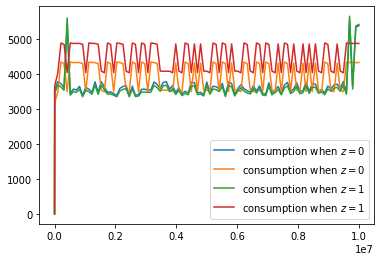

In [ ]:
#@title

fig, ax = plt.subplots()
for z in range(len(ifp.P)):
    ax.plot(a_star[:, z], σ_star[:, z], label=f"consumption when $z={z}$")

plt.legend()
plt.show()


In [ ]:
#Methods to calculate the precarity

def getEntropy(sequence):
  value,counts = np.unique(sequence, return_counts=True)
  return entropy(counts, base=2)

def generateWeight(sequence,values = Incomes, states = stateseq):
  #values = [0,50000,100000] the minimum set thresholds for the incomes for each class. Should be changed as per data. 
  #Currently first 4 levels low, next 2 middle and next 3 high so as to make sure the percentages are balanced. (data: statistia.com)
  weights = []
  for i in range(1,len(sequence)):
    m = states.index(sequence[i])
    n = states.index(sequence[i-1])
    weights.append(math.exp((1e-22)*abs(values[m]-values[n])))
  return weights

def complexity(sequence, stateSpace):
  na = len(stateSpace)
  ls= len(sequence)
  currentState = sequence[0]
  nts = 0
  for i in range(len(sequence)):
    if(sequence[i]!=currentState):
      nts += 1
      currentState = sequence[i]
  return math.sqrt((getEntropy(sequence)/math.log2(na))*(nts/(ls-1)))

def precarityQuantification(sequence, stateSpace, weights, lambdav, alpha, beta, init_state):
  currentState = sequence[0]
  negativeWts = 0
  positiveWts = 0
  for i in range(1,len(sequence)):
    if (sequence[i]>=currentState):
      positiveWts += weights[i-1]
    else:
      negativeWts += weights[i-1]
    currentState = sequence[i]
  totalWts = sum(weights)
  Qs = 0
  if (totalWts!=0):
    negativeQs = negativeWts/totalWts
    positiveQs = positiveWts/totalWts
    Qs = negativeQs - positiveQs
  else:
    print(negativeWts,positiveWts)
  init_cost = init_state#(1/(init_state+0.00001))*10000
  return lambdav*init_cost+(1-lambdav)*math.pow(complexity(sequence,stateSpace),alpha)*math.pow(1+Qs,beta)


In [ ]:
#Assets series computation (Original)
@njit
def compute_asset_series(ifp, a_star, σ_star, z_seq, T=500_000, shock = 12, init_a = offset):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t}

    """

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_star[:, z], σ_star[:, z], a)
    t_s = []
    # Simulate the asset path
    a = np.zeros(T+1)
    a[0] = init_a
    setY = ifp.modify_Y
    for t in range(T):
        z = z_seq[t]
        # print (z)
        ζ, η = np.random.randn(), np.random.randn()
        R = ifp.R(z, ζ)
        Y = ifp.Y
        # if ifp.Y(z, η) > 0.1:
        #   Y = ifp.Y(z, η)
        # else:
        #   Y = ifp.Y(z, η) - 0.1

        y_tmp = Y(z)
        if ((t+1)%shock):
          if y_tmp>= 150000:
            y_tmp = y_tmp + 2000.0
          elif (y_tmp<=40000.0):
            y_tmp = y_tmp - 2000.0
        s =  a[t] - σ(a[t], z)
        #setY(z,y_tmp,mod)
        a[t+1] = R * (s) + y_tmp
    return a

In [ ]:
#Compute asset series with internal calculation
def compute_asset_series_comp(ifp, a_star, σ_star, z_init, T=500_000, shock = 12, init_a = offset):#, P1=np.array([[1,0],[0,1]]),P2=np.array([[1,0],[0,1]])):
    # Create consumption function by linear interpolation
    σ = lambda a, z , e: interp(a_star[:, z, e], σ_star[:, z, e], a)
    t_s = []
    # Simulate the asset path
    a = np.zeros(T+1)
    z_ = np.zeros(T+1)
    a[0] = init_a
    setY = ifp.modify_Y
    P_p = ifp.P_p
    P_n = ifp.P_n
    z = z_init
    z_[0] = z
    for t in range(T):
        P = P_p[z]
        if ((t+1)%shock==0):
          P = P_n[z]
        p = np.random.rand(1)
        r = 0
        z_nxt = 0
        for i in range(len(P)):
          if (p>r):
            r += P[i]
            if (p<=r):
              z_nxt = i
              break
        z = z_nxt
        z_[t+1] = z
        ζ, η = np.random.randn(), np.random.randn()
        R = ifp.R(z, ζ)
        Y = ifp.Y
        y_tmp = Y(z)
        if ((t+1)%shock==0):
          y_tmp = y_tmp - y_tmp*0.1
          s =  a[t] - max(σ(a[t], z, 1),basic_expenditure(y_tmp))
        else:
          s = a[t] - max(σ(a[t], z, 0),basic_expenditure(y_tmp))
        a[t+1] = R * (s) + y_tmp
    return a, z_

In [ ]:
#Compute negative assets with a decreasing R
def compute_asset_series_comp_decrease(ifp, a_star, σ_star, z_init, T=500_000, shock = 12, init_a = offset):#, P1=np.array([[1,0],[0,1]]),P2=np.array([[1,0],[0,1]])):
    # Create consumption function by linear interpolation
    σ = lambda a, z , e: interp(a_star[:, z, e], σ_star[:, z, e], a)
    t_s = []
    # Simulate the asset path
    a = np.zeros(T+1)
    z_ = np.zeros(T+1)
    a[0] = init_a
    setY = ifp.modify_Y
    P_p = ifp.P_p
    P_n = ifp.P_n
    z = z_init
    z_[0] = z
    for t in range(T):
        P = P_p[z]
        if ((t+1)%shock==0):
          P = P_n[z]
        p = np.random.rand(1)
        r = 0
        z=np.random.choice(len(P),p=(P/sum(P)))
        z_[t+1] = z
        ζ, η = np.random.randn(), np.random.randn()
        R = ifp.R_decrease(a[t], 10e-5)
        Y = ifp.Y
        y_tmp = Y(z)
        if ((t+1)%shock==0):
          y_tmp = y_tmp - y_tmp*0.1
          s =  a[t] - σ(a[t], z, 1)
        else:
          s = a[t] - σ(a[t], z, 0)
        a[t+1] = R * (s) + y_tmp
    return a, z_

In [ ]:
#Calculate savings based on income
def get_savings(income):
    if income < np.percentile(incomes, 20):
        
        return  (9.30*1000) 
    if np.percentile(incomes, 20)<=income and income< np.percentile(incomes, 40):
        return (43.80*1000)
  
    if np.percentile(incomes, 40) <=income and income< np.percentile(incomes, 60):
        return (95.62*1000)
        
    if np.percentile(incomes, 60) <=income and income< np.percentile(incomes, 80) :
        return (205.20*1000)
        
    if np.percentile(incomes, 80)  <=income and income< np.percentile(incomes, 90) :
        return (387.85*1000)
        
    if income>=np.percentile(incomes, 90):
        return  (1589.30*1000)

#Get the state
def getState(indiv_savings_status):
  savings_class = []
  for idx in range(len(indiv_savings_status)):
        if indiv_savings_status[idx] <savings_10:
            savings_class.append(0)
        if indiv_savings_status[idx]>=savings_10 and indiv_savings_status[idx]<savings_20:
            savings_class.append(1)
        if indiv_savings_status[idx]>=savings_20 and indiv_savings_status[idx]<savings_30:
            savings_class.append(2)
        if indiv_savings_status[idx]>=savings_30 and indiv_savings_status[idx]<savings_40:
            savings_class.append(3)
        if indiv_savings_status[idx]>=savings_40 and indiv_savings_status[idx]<savings_50:
            savings_class.append(4)
        if indiv_savings_status[idx]>=savings_50 and indiv_savings_status[idx]<savings_60:
            savings_class.append(5)
        if indiv_savings_status[idx]>=savings_60 and indiv_savings_status[idx]<savings_70:
            savings_class.append(6)
        if indiv_savings_status[idx]>=savings_70 and indiv_savings_status[idx]<savings_80:
            savings_class.append(7)
        if indiv_savings_status[idx]>=savings_80 and indiv_savings_status[idx]<savings_90:
            savings_class.append(8)
        if indiv_savings_status[idx]>=savings_90 and indiv_savings_status[idx]<savings_99:
            savings_class.append(9)
        if indiv_savings_status[idx]>=savings_99:
            savings_class.append(10)
  return savings_class

#Weight functions
def generateWeight_savings(sequence,values, states):
    weights = []
    for i in range(1,len(sequence)):
        m = states.index(sequence[i])
        n = states.index(sequence[i-1])
        weights.append(math.exp((1e-22)*abs(values[m] - values[n])))
    return weights

def generateWeight_health(sequence,values, states):
    weights = []
    for i in range(1,len(sequence)):
        m = states.index(sequence[i])
        n = states.index(sequence[i-1])
        weights.append(math.exp( (1e-22)*abs(values[m]-values[n])))
    return weights


In [ ]:
### Precarity levels setup
bucket_coarse = {'<0.6': 0, '0.6<<1.0':0, '1.0<<1.5':0, '1.5<<1.7':0,'1.7<<1.8':0,  '1.8<<1.9' : 0, '1.9<<2.0' : 0, '2.0<<2.1' : 0, '2.1<<2.2':0, '>2.2':0 } 

def plotter_distribution(bucket_coarse, exam, u):
    
    for i in range(1,len(exam)):
        
            if (0.6>= exam [i]):
                bucket_coarse['<0.6'] += u 

            if (0.6 < exam [i] <= 1.0):
                bucket_coarse['0.6<<1.0'] += u

            if (1.0 < exam [i] <= 1.5):
                bucket_coarse['1.0<<1.5'] += u

            if (1.5 < exam [i] <= 1.7):
                bucket_coarse['1.5<<1.7'] += u
                
            if (1.7 < exam [i] <= 1.8):
                bucket_coarse['1.7<<1.8'] += u 
                
            if (1.8 < exam[i] <= 1.9):
                 bucket_coarse['1.8<<1.9'] += u
                    
            if (1.9< exam[i] <= 2.0):
                 bucket_coarse['1.9<<2.0'] += u
                    
            if (2.0 < exam[i] <=2.1 ):
                 bucket_coarse['2.0<<2.1'] += u

            if (2.1 < exam[i] <=2.2 ):
                 bucket_coarse['2.1<<2.2'] += u

            if (2.2 < exam[i]):
                bucket_coarse['>2.2'] += u
                
    return bucket_coarse
def plotter_distribution_health(exam , u):
    bucket_coarse={'<1.6':0,'1.6<<1.7':0,'1.7<<1.8':0,'1.8<<1.9':0,'1.9<<2.0':0,'2.0<<2.1':0,'2.1<<2.3':0,'2.3<<2.5':0,'2.5<<2.8':0,'>2.8':0}
    for i in range(1,len(exam)):
        
            if (1.6>= exam [i]):
                bucket_coarse['<1.6'] += u  
            if (1.6 < exam [i] <= 1.7):
                bucket_coarse['1.6<<1.7'] += u 
            if (1.7 < exam [i] <= 1.8):
                bucket_coarse['1.7<<1.8'] += u
            if (1.8 < exam [i] <= 1.9):
                bucket_coarse['1.8<<1.9'] += u 
            if (1.9 < exam [i] <= 2.0):
                bucket_coarse['1.9<<2.0'] += u 
            if (2.0 < exam [i] <= 2.1):
                bucket_coarse['2.0<<2.1'] += u 
                
            if (2.1 < exam[i] <= 2.3):
                 bucket_coarse['2.1<<2.3'] += u
                    
            if (2.3< exam[i] <= 2.5):
                 bucket_coarse['2.3<<2.5'] += u
                    
            if (2.5 < exam[i] <=2.8 ):
                 bucket_coarse['2.5<<2.8'] += u
            if (2.8 < exam[i]):
                bucket_coarse['>2.8'] += u
                
    return bucket_coarse

In [ ]:
def getIncomeClass(income):
        if income<inc_10:
            return (0)
        if income>=inc_10 and income<inc_20:
            return (1)
        if income>=inc_20 and income<inc_30:
            return (2)
        if income>=inc_30 and income<inc_40:
            return (3)
        if income>=inc_40 and income<inc_50:
            return (4)
        if income>=inc_50 and income<inc_60:
            return (5)
        if income>=inc_60 and income<inc_70:
            return (6)
        if income>=inc_70 and income<inc_80:
            return (7)
        if income>=inc_80 and income<inc_90:
            return (8)
        if income>=inc_90 and income<inc_99:
            return (9)
        if income>=inc_99:
            return (10)

In [ ]:
#Compute asset series with internal calculation
def compute_asset_series_comp_health(ifp, a_star, σ_star, z_init, initincome, T=500_000, shock = 12, init_a = offset, intervention = False, Type='Add', round = -1):#, P1=np.array([[1,0],[0,1]]),P2=np.array([[1,0],[0,1]])):
    # Create consumption function by linear interpolation
    σ = lambda a, z , e: interp(a_star[:, z, e], σ_star[:, z, e], a)
    t_s = []
    # Simulate the asset path
    a = np.zeros(T+1)
    z_ = np.zeros(T+1)
    a[0] = init_a
    setY = ifp.modify_Y
    P_p = ifp.P_p
    P_n = ifp.P_n
    z = z_init
    z_[0] = z
    y_val = [initincome]
    current_income = initincome
    h_=[final_health_index(initincome)]
    for t in range(T):
        if (current_income>=clf_threshold_Q5):
          P = P_p[z]
        else:
          P = P_n[z]
        z_prev = z
        if (Type=='Prob' and intervention):
          P[z] = 5/9
        z = np.random.choice(len(P),p=(P/sum(P)))
        z_[t+1] = z
        ζ, η = np.random.randn(), np.random.randn()
        R = ifp.R(z, ζ)
        Y = ifp.Y
        y_tmp = Y(z)
        if (intervention):
          if (Type=='Add' and current_income<clf_threshold_Q5):
            y_tmp = y_tmp + 1500
        if (current_income>=clf_threshold_Q5 and z>z_prev):
          y_tmp *= 1.1
        elif (current_income<clf_threshold_Q5 and z<z_prev):
          y_tmp = 0.9*y_tmp
        if (current_income>=clf_threshold_Q5):
          s = a[t] - σ(a[t], z, 0)
        else:
          s = a[t] - σ(a[t], z, 1)
        h_.append(final_health_index(y_tmp))
        y_val.append(y_tmp)
        current_income = y_tmp
        a[t+1] = R * (s) + y_tmp
    return a, z_,h_,y_val

In [ ]:
bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 } 

def plotter_distribution_networth_all(bucket_coarse, exam, u):
    
    for i in range(1,len(exam)):
        
            if (0.5>= exam [i]):
                bucket_coarse['=<0.5'] += u  
                                
            if (0.5 < exam[i] <= 1):
                 bucket_coarse['0.5<<=1'] += u
      
            if (1 < exam[i] <=1.8 ):
                 bucket_coarse['1<<1.8'] += u
           
        
                    
            if (1.8 < exam[i]):
                bucket_coarse['>1.8'] += u
                
    return bucket_coarse

bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}

def plotter_distribution_health_all(bucket_coarse, exam, u):
   
   for i in range(1,len(exam)):
       
           if (0.5>= exam [i]):
               bucket_coarse['=<0.5'] += u  
               
           if (0.5 < exam [i] <= 1):
               bucket_coarse['0.5<<=1'] += u
               
           if ( 1 <exam[i] <=1.5 ):
                bucket_coarse['1<<=1.5'] += u
           if ( 1.5<exam[i]<=2):
                bucket_coarse['1.5<<=2'] += u
           if ( 2<exam[i] <= 2.5 ):
                bucket_coarse['2<<=2.5'] += u
           if ( 2.5<exam[i]  ):
                bucket_coarse['2.5>'] += u
         
               
   return bucket_coarse


def plotter_distribution_health_all_2(bucket_coarse,exam , u):
    for i in range(1,len(exam)):
        
            if (0.6>= exam [i]):
                bucket_coarse['<0.6'] += u  
            if (0.6 < exam [i] <= 0.8):
                bucket_coarse['0.6<<0.8'] += u
            if (0.8 < exam [i] <= 1.0):
                bucket_coarse['0.8<<1.0'] += u 
            if (1.0 < exam [i] <= 1.2):
                bucket_coarse['1.0<<1.2'] += u
            if (1.2 < exam [i] <= 1.4):
                bucket_coarse['1.2<<1.4'] += u
            if (1.4 < exam [i] <= 1.6):
                bucket_coarse['1.4<<1.6'] += u 
            if (1.6 < exam [i] <= 1.8):
                bucket_coarse['1.6<<1.8'] += u 
            if (1.8 < exam [i] <= 2.0):
                bucket_coarse['1.8<<2.0'] += u 
            if (2.0 < exam [i] <= 2.3):
                bucket_coarse['2.0<<2.3'] += u 
            if (2.3 < exam[i]):
                bucket_coarse['>2.3'] += u
                
    return bucket_coarse

bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }

def plotter_distribution_income_all(bucket_coarse, exam, u):
   
  for i in range(1,len(exam)):

           if (0.2>= exam [i]):
               bucket_coarse['>=0.2'] += u  
               
           if (0.2 < exam [i] <= 0.5):
               bucket_coarse['0.2<<=0.5'] += u
               
           if (0.5 < exam [i] <= 0.8):
               bucket_coarse['0.5<<=0.8'] += u
               
           if (0.8 < exam[i] <= 1.2):
                bucket_coarse['0.8<<=1.2'] += u
                   
           if (1.2< exam[i] <= 1.5):
                bucket_coarse['1.2<<=1.5'] += u
                   
           if (1.5 < exam[i] <=2.5 ):
                bucket_coarse['1.5<<=2.5'] += u
                   
           if (2.5< exam[i] ):
                bucket_coarse['2.5>'] += u
  return bucket_coarse

{'=<0.5': 1000, '0.5<<=1': 2888, '1<<1.8': 5999, '>1.8': 112} 9999
{'=<0.5': 1000, '0.5<<=1': 2802, '1<<1.8': 5202, '>1.8': 995} 9999
{'=<0.5': 1000, '0.5<<=1': 2639, '1<<1.8': 5227, '>1.8': 1133} 9999
{'=<0.5': 1000, '0.5<<=1': 2552, '1<<1.8': 5270, '>1.8': 1177} 9999
{'=<0.5': 1000, '0.5<<=1': 2490, '1<<1.8': 5297, '>1.8': 1212} 9999
{'=<0.5': 1000, '0.5<<=1': 2447, '1<<1.8': 5313, '>1.8': 1239} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

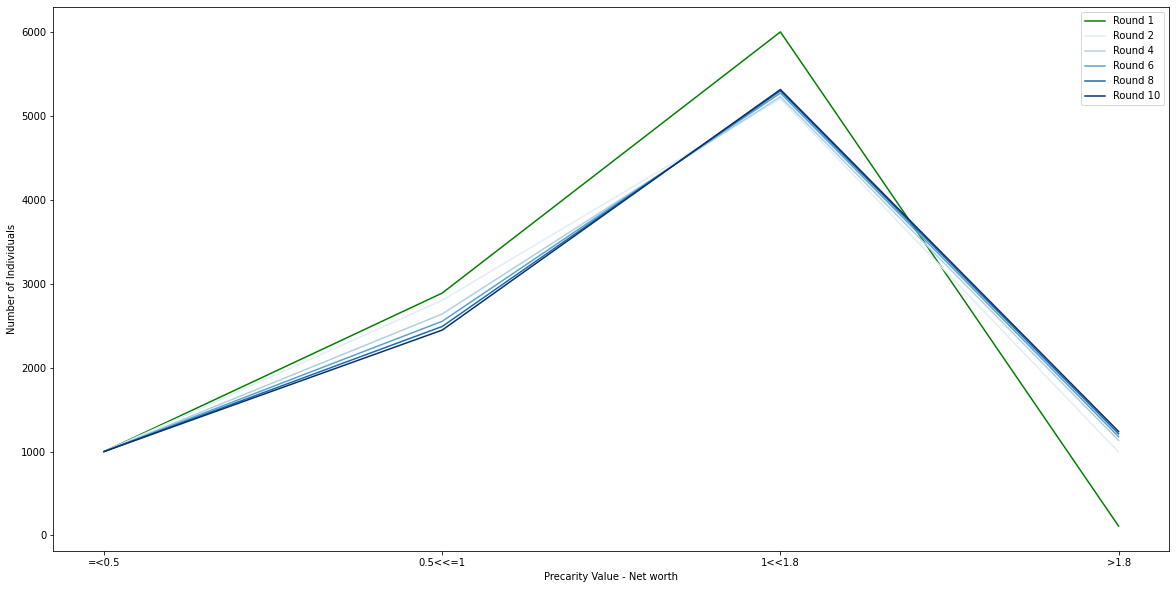

(10000, 10) 10
{'=<0.5': 187, '0.5<<=1': 637, '1<<=1.5': 2002, '1.5<<=2': 5362, '2<<=2.5': 1811, '2.5>': 0} 9999
{'=<0.5': 112, '0.5<<=1': 1674, '1<<=1.5': 3347, '1.5<<=2': 3326, '2<<=2.5': 1179, '2.5>': 361} 9999
{'=<0.5': 497, '0.5<<=1': 1982, '1<<=1.5': 2622, '1.5<<=2': 3203, '2<<=2.5': 1648, '2.5>': 47} 9999
{'=<0.5': 462, '0.5<<=1': 1914, '1<<=1.5': 3261, '1.5<<=2': 2481, '2<<=2.5': 1818, '2.5>': 63} 9999
{'=<0.5': 317, '0.5<<=1': 2433, '1<<=1.5': 2733, '1.5<<=2': 2579, '2<<=2.5': 1891, '2.5>': 46} 9999
{'=<0.5': 567, '0.5<<=1': 2192, '1<<=1.5': 2867, '1.5<<=2': 2321, '2<<=2.5': 2039, '2.5>': 13} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

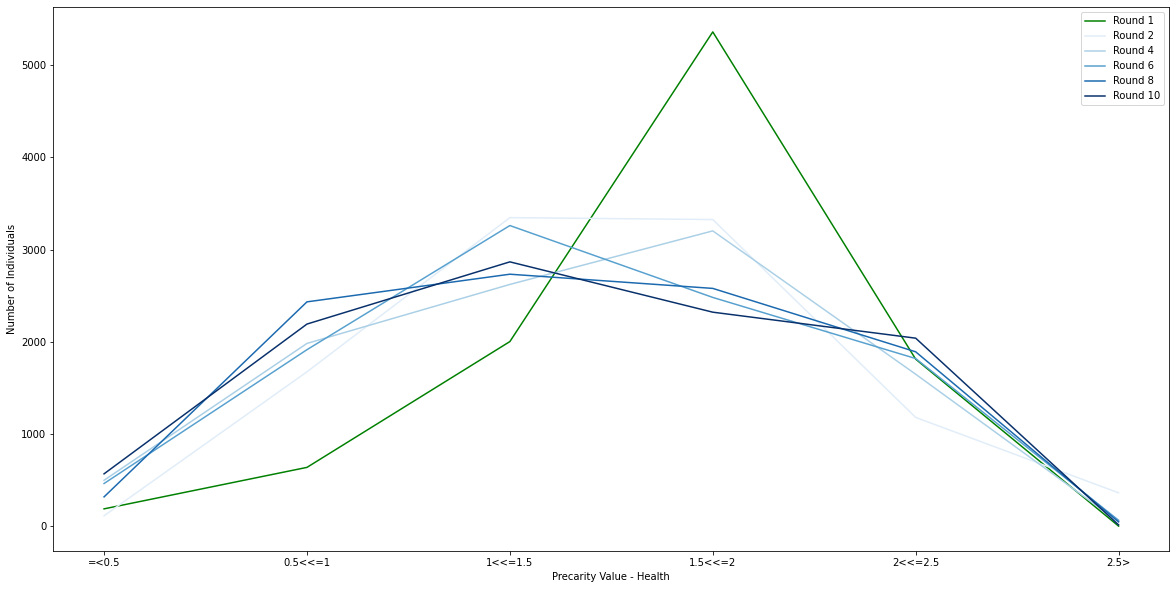

{'>=0.2': 64, '0.2<<=0.5': 811, '0.5<<=0.8': 1418, '0.8<<=1.2': 880, '1.2<<=1.5': 1758, '1.5<<=2.5': 3925, '2.5>': 1143} 9999
{'>=0.2': 36, '0.2<<=0.5': 644, '0.5<<=0.8': 1049, '0.8<<=1.2': 1476, '1.2<<=1.5': 1831, '1.5<<=2.5': 4210, '2.5>': 753} 9999
{'>=0.2': 10, '0.2<<=0.5': 278, '0.5<<=0.8': 1238, '0.8<<=1.2': 1622, '1.2<<=1.5': 1766, '1.5<<=2.5': 4321, '2.5>': 764} 9999
{'>=0.2': 3, '0.2<<=0.5': 185, '0.5<<=0.8': 1117, '0.8<<=1.2': 1873, '1.2<<=1.5': 1542, '1.5<<=2.5': 4544, '2.5>': 735} 9999
{'>=0.2': 0, '0.2<<=0.5': 187, '0.5<<=0.8': 946, '0.8<<=1.2': 1913, '1.2<<=1.5': 1742, '1.5<<=2.5': 4469, '2.5>': 742} 9999
{'>=0.2': 0, '0.2<<=0.5': 130, '0.5<<=0.8': 945, '0.8<<=1.2': 1987, '1.2<<=1.5': 1598, '1.5<<=2.5': 4599, '2.5>': 740} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

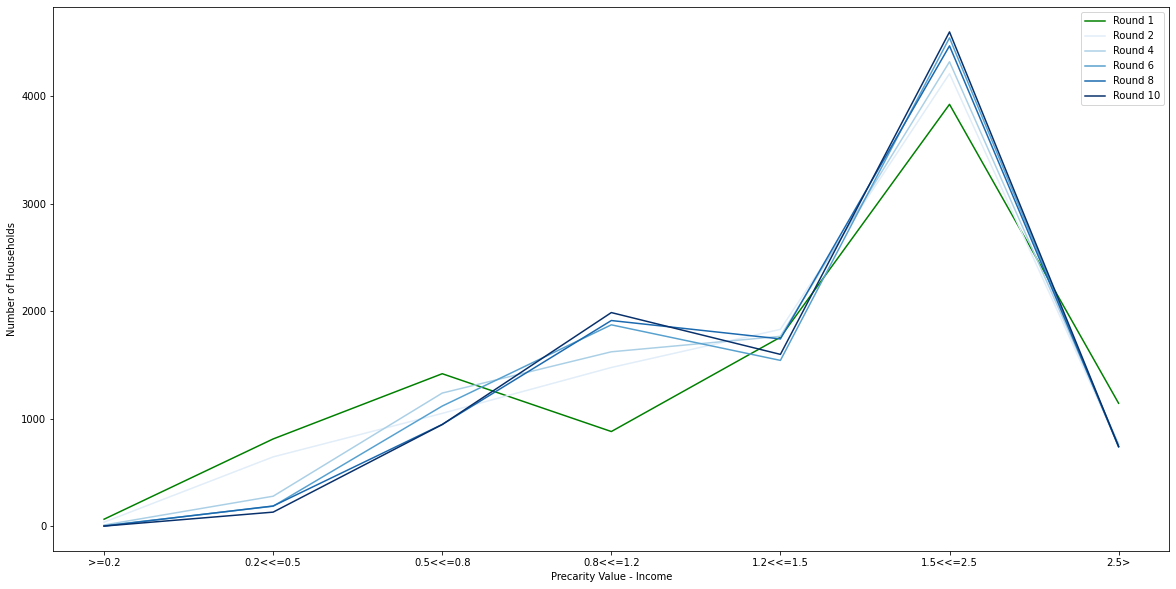

In [ ]:
#Testing on all individuals 
original_income=[]
original_assets= []
original_health = []
original_health_2 = []
np.random.seed(1234)
random.seed(1234)
T = iterations
P = 2
st = 0
m = len(incomes)
a_ = []
prec_ = []
prec_h = []
prec_s=[]
c = np.arange(8, 18)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

for j in range(m):
  init_income = incomes[j]
  init_saving = get_savings(init_income)
  init_state = getState([init_saving])[0]
  st = getIncomeClass(init_income)
  a, z, h, inc = compute_asset_series_comp_health(ifp, a_star, σ_star, st, init_income, T=T, shock = P, init_a = init_saving,round=j)
  precarity = []#[0.2*(11-init_state)]
  h_st = getHealthStat(final_health_index(init_income))
  precarity_health = []#[0.2*(11-h_st)]
  a_.append(a)
  h = np.array([getHealthStat(i) for i in h])
  inc_class = np.array([getIncomeClass(i) for i in inc])
  precarity_income = []#[0.2*(11-inc_class[0])]
  for i in range(1,len(z)):
    weights_income =  generateWeight(inc_class[:i+1],values = [inc_10,inc_20,inc_30,inc_40,inc_50,inc_60,inc_70,inc_80,inc_90,inc_99,800000.00/12], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_income.append(precarityQuantification(inc_class[:i+1], [0,1,2,3,4,5,6,7,8,9,10], weights_income, 0.2, 1, 1.2, 11-h_st))
  prec_s.append(precarity_income)
  for i in range(1,len(h)):
    weights_health =  generateWeight_health(h[:i+1],values = [health_10,health_20,health_30,health_40,health_50,health_60,health_70,health_80,health_90,health_99,60], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_health.append(precarityQuantification(h[:i+1], [0,1,2,3,4,5,6,7,8,9, 10], weights_health, 0.2, 1, 1.2, 11-h_st))
  prec_h.append(precarity_health)
  for i in range(1,len(a)):
    weights_savings = generateWeight_savings(getState(a[:i+1]), values = savings_values, states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity.append(precarityQuantification(getState(a[:i+1]), [0,1,2,3,4,5,6,7,8,9, 10], weights_savings, 0.2, 1, 1.2, 11-init_state))
  prec_.append(precarity)
prec_ = np.array(prec_)
prec_h = np.array(prec_h)  
a_ = np.array(a_)
Rounds = RoundsToDisplay
plt.figure(0, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 }
  y = list((plotter_distribution_networth_all(bucket_coarse, prec_[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    original_assets = y
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Individuals')
  plt.xlabel('Precarity Value - Net worth')
plt.savefig('ifp_precairty-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty-TransitionOriginal.png')
plt.legend()
plt.show()
print(prec_.shape,T)

plt.figure(1, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}
  y = list((plotter_distribution_health_all(bucket_coarse, prec_h[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    original_health = y
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Individuals')
  plt.xlabel('Precarity Value - Health')
plt.savefig('ifp_precairty_health-TransitionOriginal.png',bbox_inches='tight')

files.download('ifp_precairty_health-TransitionOriginal.png')
plt.legend()
plt.show()

prec_s = np.array(prec_s)
plt.figure(2, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }
  y = list((plotter_distribution_income_all(bucket_coarse, prec_s[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    original_income = y
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Income')
plt.savefig('ifp_precairty_income-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_income-TransitionOriginal.png')
plt.legend()
plt.show()

{'=<0.5': 1000, '0.5<<=1': 2908, '1<<1.8': 5999, '>1.8': 92} 9999
{'=<0.5': 1000, '0.5<<=1': 2814, '1<<1.8': 4964, '>1.8': 1221} 9999
{'=<0.5': 1000, '0.5<<=1': 2670, '1<<1.8': 4988, '>1.8': 1341} 9999
{'=<0.5': 1000, '0.5<<=1': 2581, '1<<1.8': 5036, '>1.8': 1382} 9999
{'=<0.5': 1000, '0.5<<=1': 2507, '1<<1.8': 5086, '>1.8': 1406} 9999
{'=<0.5': 1000, '0.5<<=1': 2452, '1<<1.8': 5117, '>1.8': 1430} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

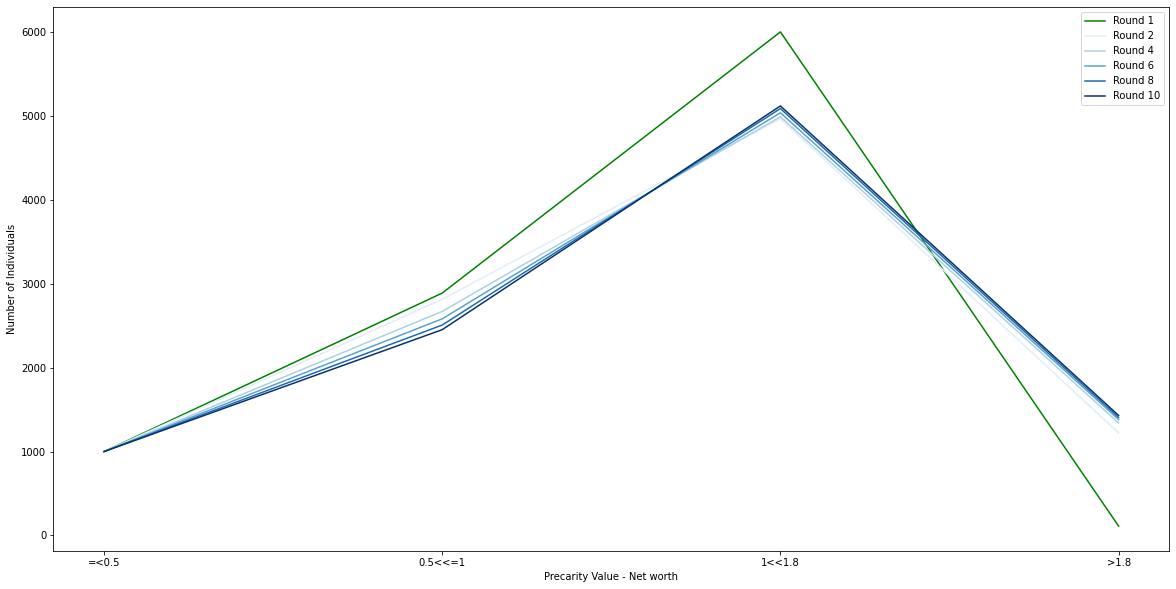

(10000, 10) 10
{'=<0.5': 330, '0.5<<=1': 554, '1<<=1.5': 1818, '1.5<<=2': 5445, '2<<=2.5': 1852, '2.5>': 0} 9999
{'=<0.5': 209, '0.5<<=1': 1618, '1<<=1.5': 3544, '1.5<<=2': 3233, '2<<=2.5': 1100, '2.5>': 295} 9999
{'=<0.5': 624, '0.5<<=1': 1980, '1<<=1.5': 2747, '1.5<<=2': 3120, '2<<=2.5': 1498, '2.5>': 30} 9999
{'=<0.5': 593, '0.5<<=1': 1898, '1<<=1.5': 3307, '1.5<<=2': 2491, '2<<=2.5': 1676, '2.5>': 34} 9999
{'=<0.5': 446, '0.5<<=1': 2400, '1<<=1.5': 2854, '1.5<<=2': 2541, '2<<=2.5': 1738, '2.5>': 20} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


{'=<0.5': 684, '0.5<<=1': 2181, '1<<=1.5': 2941, '1.5<<=2': 2313, '2<<=2.5': 1874, '2.5>': 6} 9999


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

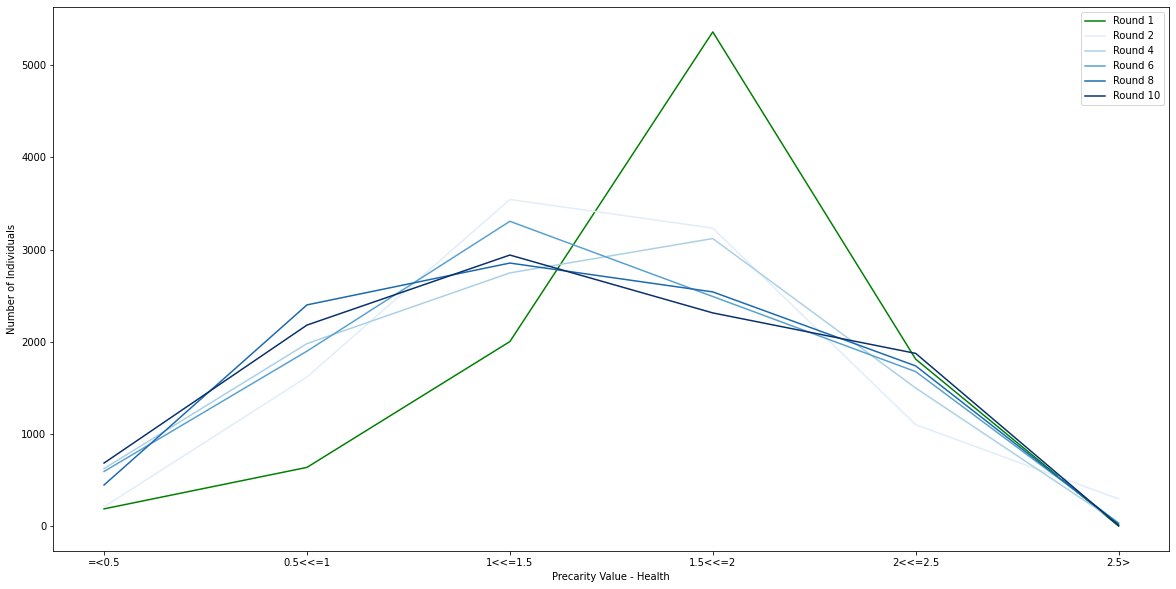

{'>=0.2': 67, '0.2<<=0.5': 823, '0.5<<=0.8': 1513, '0.8<<=1.2': 911, '1.2<<=1.5': 1807, '1.5<<=2.5': 3920, '2.5>': 958} 9999
{'>=0.2': 42, '0.2<<=0.5': 709, '0.5<<=0.8': 1207, '0.8<<=1.2': 1478, '1.2<<=1.5': 1872, '1.5<<=2.5': 4186, '2.5>': 505} 9999
{'>=0.2': 13, '0.2<<=0.5': 449, '0.5<<=0.8': 1371, '0.8<<=1.2': 1670, '1.2<<=1.5': 1720, '1.5<<=2.5': 4236, '2.5>': 540} 9999
{'>=0.2': 4, '0.2<<=0.5': 349, '0.5<<=0.8': 1279, '0.8<<=1.2': 1881, '1.2<<=1.5': 1627, '1.5<<=2.5': 4413, '2.5>': 446} 9999
{'>=0.2': 1, '0.2<<=0.5': 398, '0.5<<=0.8': 1129, '0.8<<=1.2': 1960, '1.2<<=1.5': 1705, '1.5<<=2.5': 4342, '2.5>': 464} 9999
{'>=0.2': 0, '0.2<<=0.5': 285, '0.5<<=0.8': 1162, '0.8<<=1.2': 2062, '1.2<<=1.5': 1593, '1.5<<=2.5': 4481, '2.5>': 416} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

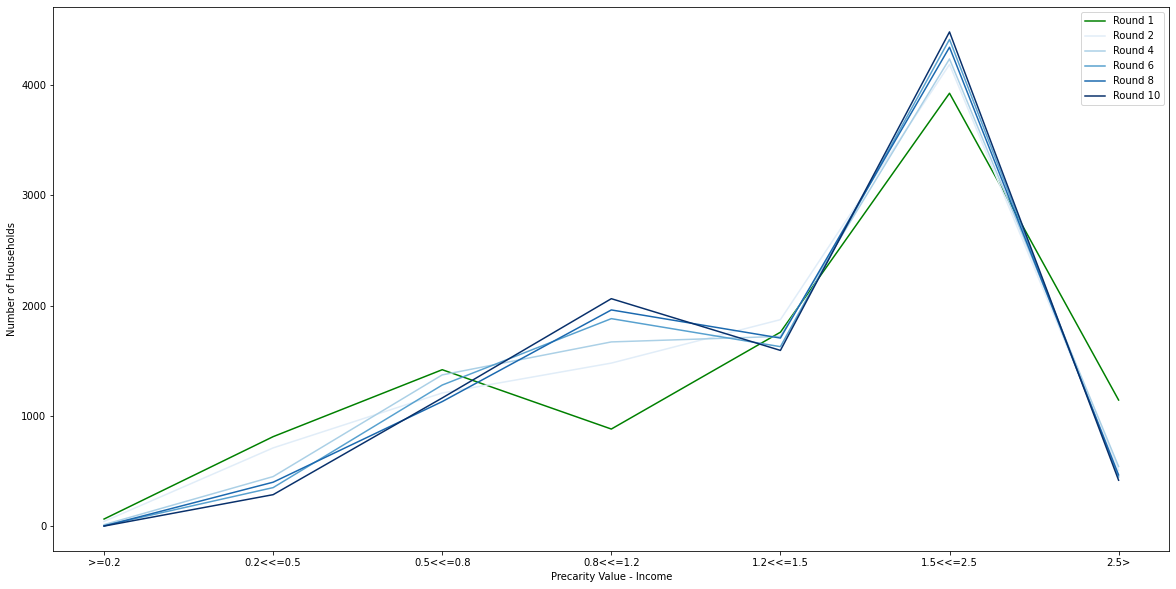

In [ ]:
#All individuals (with probability interventions)
np.random.seed(1234)
random.seed(1234)
T = iterations
P = 2
st = 0
m = len(incomes)
a_ = []
prec_ = []
prec_h = []
prec_s=[]
c = np.arange(8, 18)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

for j in range(m):
  init_income = incomes[j]
  init_saving = get_savings(init_income)
  init_state = getState([init_saving])[0]
  st = getIncomeClass(init_income)
  a, z, h, inc = compute_asset_series_comp_health(ifp, a_star, σ_star, st, init_income, T=T, shock = P, init_a = init_saving, intervention=True, Type='Prob',round=j)
  precarity = []#[0.2*(11-init_state)]
  h_st = getHealthStat(final_health_index(init_income))
  precarity_health = []#[0.2*(11-h_st)]
  a_.append(a)
  h = np.array([getHealthStat(i) for i in h])
  inc_class = np.array([getIncomeClass(i) for i in inc])
  precarity_income = []#[0.2*(11-inc_class[0])]
  for i in range(1,len(z)):
    weights_income =  generateWeight(inc_class[:i+1],values = [inc_10,inc_20,inc_30,inc_40,inc_50,inc_60,inc_70,inc_80,inc_90,inc_99,800000.00/12], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_income.append(precarityQuantification(inc_class[:i+1], [0,1,2,3,4,5,6,7,8,9,10], weights_income, 0.2, 1, 1.2, 11-h_st))
  prec_s.append(precarity_income)
  for i in range(1,len(h)):
    weights_health =  generateWeight_health(h[:i+1],values = [health_10,health_20,health_30,health_40,health_50,health_60,health_70,health_80,health_90,health_99,60], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_health.append(precarityQuantification(h[:i+1], [0,1,2,3,4,5,6,7,8,9, 10], weights_health, 0.2, 1, 1.2, 11-h_st))
  prec_h.append(precarity_health)
  for i in range(1,len(a)):
    weights_savings = generateWeight_savings(getState(a[:i+1]), values = savings_values, states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity.append(precarityQuantification(getState(a[:i+1]), [0,1,2,3,4,5,6,7,8,9, 10], weights_savings, 0.2, 1, 1.2, 11-init_state))
  prec_.append(precarity)
prec_ = np.array(prec_)
prec_h = np.array(prec_h)  
a_ = np.array(a_)
Rounds = RoundsToDisplay 
plt.figure(0, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 }
  y = list((plotter_distribution_networth_all(bucket_coarse,prec_[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),original_assets,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Individuals')
  plt.xlabel('Precarity Value - Net worth')
plt.savefig('ifp_precairty-InterventionProb-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty-InterventionProb-TransitionOriginal.png')
plt.legend()
plt.show()
print(prec_.shape,T)

plt.figure(1, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}
  y = list((plotter_distribution_health_all(bucket_coarse,prec_h[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),original_health,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Individuals')
  plt.xlabel('Precarity Value - Health')
plt.savefig('ifp_precairty_health-InterventionProb-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_health-InterventionProb-TransitionOriginal.png')
plt.legend()
plt.show()

prec_s = np.array(prec_s)
plt.figure(2, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }
  y = list((plotter_distribution_income_all(bucket_coarse,prec_s[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),original_income,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Income')
plt.savefig('ifp_precairty_income-InterventionProb-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_income-InterventionProb-TransitionOriginal.png')
plt.legend()
plt.show()

{'=<0.5': 1000, '0.5<<=1': 2908, '1<<1.8': 5999, '>1.8': 92} 9999
{'=<0.5': 1000, '0.5<<=1': 2876, '1<<1.8': 6123, '>1.8': 0} 9999
{'=<0.5': 1000, '0.5<<=1': 2793, '1<<1.8': 6092, '>1.8': 114} 9999
{'=<0.5': 1000, '0.5<<=1': 2755, '1<<1.8': 6061, '>1.8': 183} 9999
{'=<0.5': 1000, '0.5<<=1': 2719, '1<<1.8': 6053, '>1.8': 227} 9999
{'=<0.5': 1000, '0.5<<=1': 2697, '1<<1.8': 6043, '>1.8': 259} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

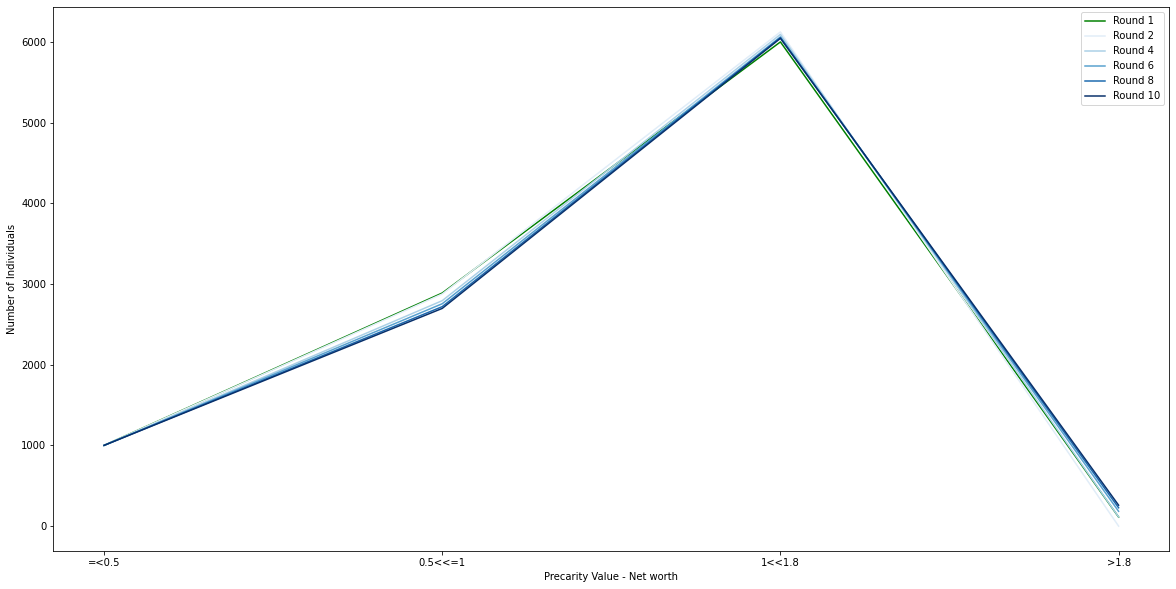

(10000, 10) 10
{'=<0.5': 23, '0.5<<=1': 1222, '1<<=1.5': 2547, '1.5<<=2': 4656, '2<<=2.5': 1430, '2.5>': 121} 9999
{'=<0.5': 80, '0.5<<=1': 1792, '1<<=1.5': 2559, '1.5<<=2': 3541, '2<<=2.5': 1656, '2.5>': 371} 9999
{'=<0.5': 155, '0.5<<=1': 1836, '1<<=1.5': 2557, '1.5<<=2': 3013, '2<<=2.5': 2253, '2.5>': 185} 9999
{'=<0.5': 157, '0.5<<=1': 1730, '1<<=1.5': 2833, '1.5<<=2': 2705, '2<<=2.5': 2316, '2.5>': 258} 9999
{'=<0.5': 117, '0.5<<=1': 2025, '1<<=1.5': 2512, '1.5<<=2': 2675, '2<<=2.5': 2462, '2.5>': 208} 9999
{'=<0.5': 144, '0.5<<=1': 1957, '1<<=1.5': 2623, '1.5<<=2': 2554, '2<<=2.5': 2553, '2.5>': 168} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

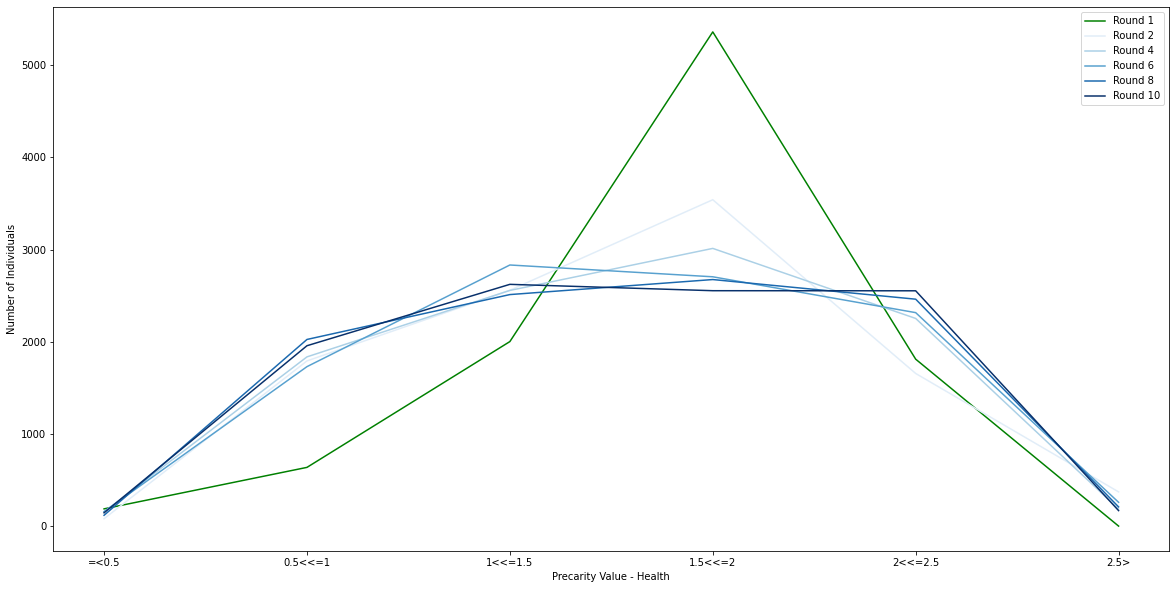

{'>=0.2': 67, '0.2<<=0.5': 834, '0.5<<=0.8': 1525, '0.8<<=1.2': 913, '1.2<<=1.5': 1807, '1.5<<=2.5': 3914, '2.5>': 939} 9999
{'>=0.2': 42, '0.2<<=0.5': 501, '0.5<<=0.8': 1065, '0.8<<=1.2': 1573, '1.2<<=1.5': 1748, '1.5<<=2.5': 4446, '2.5>': 624} 9999
{'>=0.2': 13, '0.2<<=0.5': 212, '0.5<<=0.8': 1281, '0.8<<=1.2': 1587, '1.2<<=1.5': 1722, '1.5<<=2.5': 4511, '2.5>': 673} 9999
{'>=0.2': 4, '0.2<<=0.5': 167, '0.5<<=0.8': 1129, '0.8<<=1.2': 1856, '1.2<<=1.5': 1464, '1.5<<=2.5': 4731, '2.5>': 648} 9999
{'>=0.2': 1, '0.2<<=0.5': 186, '0.5<<=0.8': 924, '0.8<<=1.2': 1885, '1.2<<=1.5': 1739, '1.5<<=2.5': 4604, '2.5>': 660} 9999
{'>=0.2': 0, '0.2<<=0.5': 141, '0.5<<=0.8': 925, '0.8<<=1.2': 1965, '1.2<<=1.5': 1563, '1.5<<=2.5': 4743, '2.5>': 662} 9999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

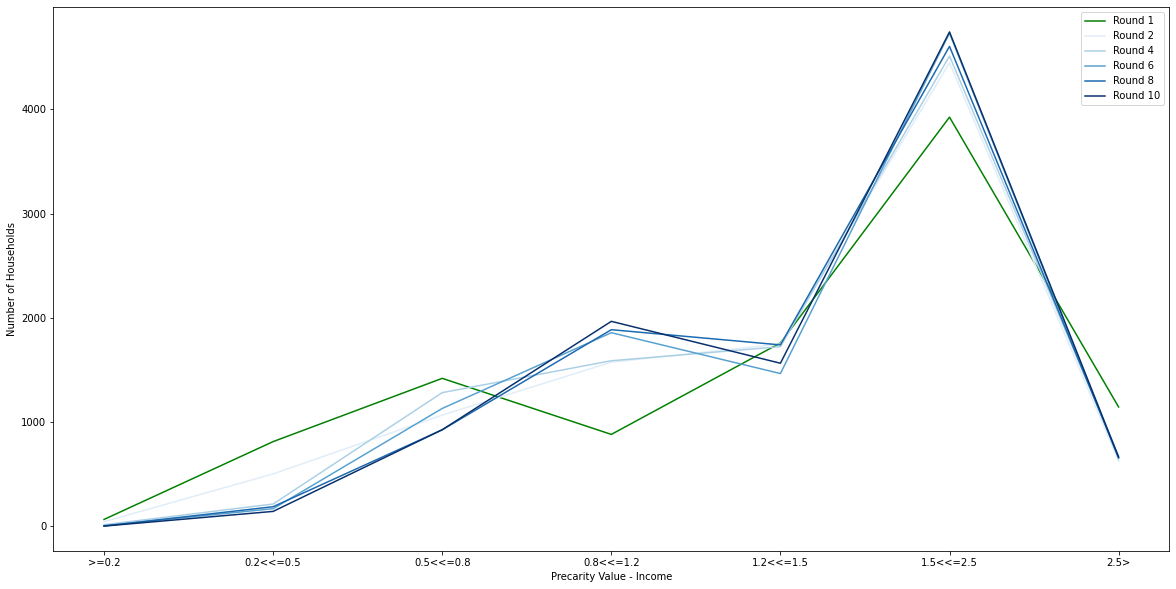

In [ ]:
#All individuals (with Additive Interventions)
np.random.seed(1234)
random.seed(1234)
T = iterations
P = 2
st = 0
m = len(incomes)
a_ = []
prec_ = []
prec_h = []
prec_s=[]
c = np.arange(8, 18)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

for j in range(m):
  init_income = incomes[j]
  init_saving = get_savings(init_income)
  init_state = getState([init_saving])[0]
  st = getIncomeClass(init_income)
  a, z, h, inc = compute_asset_series_comp_health(ifp, a_star, σ_star, st,init_income, T=T, shock = P, init_a = init_saving, intervention=True, Type = 'Add')
  precarity = []#[0.2*(11-init_state)]
  h_st = getHealthStat(final_health_index(init_income))
  precarity_health = []#[0.2*(11-h_st)]
  a_.append(a)
  h = np.array([getHealthStat(i) for i in h])
  inc_class = np.array([getIncomeClass(i) for i in inc])
  precarity_income = []#[0.2*(11-inc_class[0])]
  for i in range(1,len(z)):
    weights_income =  generateWeight(inc_class[:i+1],values = [inc_10,inc_20,inc_30,inc_40,inc_50,inc_60,inc_70,inc_80,inc_90,inc_99,800000.00/12], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_income.append(precarityQuantification(inc_class[:i+1], [0,1,2,3,4,5,6,7,8,9,10], weights_income, 0.2, 1, 1.2, 11-h_st))
  prec_s.append(precarity_income)
  for i in range(1,len(h)):
    weights_health =  generateWeight_health(h[:i+1],values = [health_10,health_20,health_30,health_40,health_50,health_60,health_70,health_80,health_90,health_99,60], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_health.append(precarityQuantification(h[:i+1], [0,1,2,3,4,5,6,7,8,9, 10], weights_health, 0.2, 1, 1.2, 11-h_st))
  prec_h.append(precarity_health)
  for i in range(1,len(a)):
    weights_savings = generateWeight_savings(getState(a[:i+1]), values = savings_values, states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity.append(precarityQuantification(getState(a[:i+1]), [0,1,2,3,4,5,6,7,8,9, 10], weights_savings, 0.2, 1, 1.2, 11-init_state))
  prec_.append(precarity)
prec_ = np.array(prec_)
prec_h = np.array(prec_h)  
a_ = np.array(a_)
Rounds = RoundsToDisplay 
plt.figure(0, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 }
  y = list((plotter_distribution_networth_all(bucket_coarse,prec_[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),original_assets,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Individuals')
  plt.xlabel('Precarity Value - Net worth')
plt.savefig('ifp_precairty-intervention1500-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty-intervention1500-TransitionOriginal.png')
plt.legend()
plt.show()
print(prec_.shape,T)

plt.figure(1, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}
  y = list((plotter_distribution_health_all(bucket_coarse,prec_h[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),original_health,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Individuals')
  plt.xlabel('Precarity Value - Health')
plt.savefig('ifp_precairty_health-interventions1500-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_health-interventions1500-TransitionOriginal.png')
plt.legend()
plt.show()

prec_s = np.array(prec_s)
plt.figure(2, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }
  y = list((plotter_distribution_income_all(bucket_coarse,prec_s[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),original_income,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Income')
plt.savefig('ifp_precairty_income-interventions1500-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_income-interventions1500-TransitionOriginal.png')
plt.legend()
plt.show()

In [ ]:
#Divide the group based on income levels

low_level = np.percentile(incomes,29)
mid_level = np.percentile(incomes,29+52)
low_level_people = []
mid_level_people = []
hih_level_people = []
for i in range(len(incomes)):
  if (incomes[i]<=low_level):
    low_level_people.append(incomes[i])
  elif (low_level<incomes[i]<=mid_level):
    mid_level_people.append(incomes[i])
  else:
    hih_level_people.append(incomes[i])

{'=<0.5': 0, '0.5<<=1': 0, '1<<1.8': 2899, '>1.8': 0} 2899
{'=<0.5': 0, '0.5<<=1': 0, '1<<1.8': 1654, '>1.8': 1245} 2899
{'=<0.5': 0, '0.5<<=1': 0, '1<<1.8': 1533, '>1.8': 1366} 2899
{'=<0.5': 0, '0.5<<=1': 0, '1<<1.8': 1501, '>1.8': 1398} 2899
{'=<0.5': 0, '0.5<<=1': 0, '1<<1.8': 1480, '>1.8': 1419} 2899
{'=<0.5': 0, '0.5<<=1': 0, '1<<1.8': 1455, '>1.8': 1444} 2899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

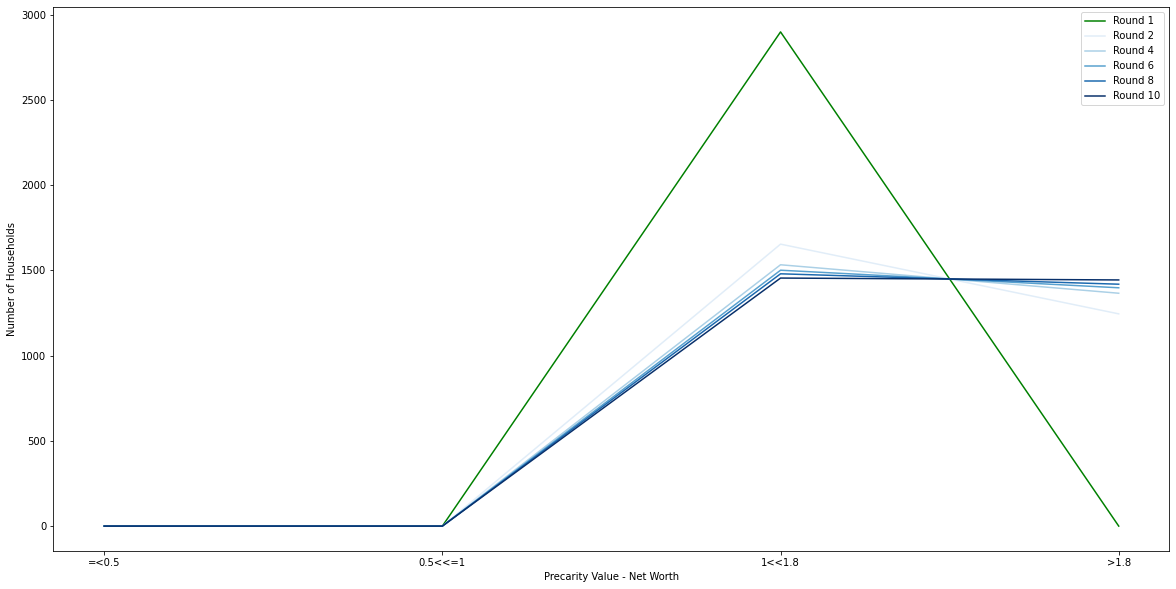

{'=<0.5': 0, '0.5<<=1': 85, '1<<=1.5': 556, '1.5<<=2': 1827, '2<<=2.5': 431, '2.5>': 0} 2899
{'=<0.5': 0, '0.5<<=1': 28, '1<<=1.5': 1423, '1.5<<=2': 1353, '2<<=2.5': 87, '2.5>': 8} 2899
{'=<0.5': 0, '0.5<<=1': 214, '1<<=1.5': 1257, '1.5<<=2': 1306, '2<<=2.5': 122, '2.5>': 0} 2899
{'=<0.5': 0, '0.5<<=1': 148, '1<<=1.5': 1517, '1.5<<=2': 1079, '2<<=2.5': 155, '2.5>': 0} 2899
{'=<0.5': 0, '0.5<<=1': 222, '1<<=1.5': 1406, '1.5<<=2': 1108, '2<<=2.5': 163, '2.5>': 0} 2899
{'=<0.5': 0, '0.5<<=1': 225, '1<<=1.5': 1448, '1.5<<=2': 1027, '2<<=2.5': 199, '2.5>': 0} 2899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

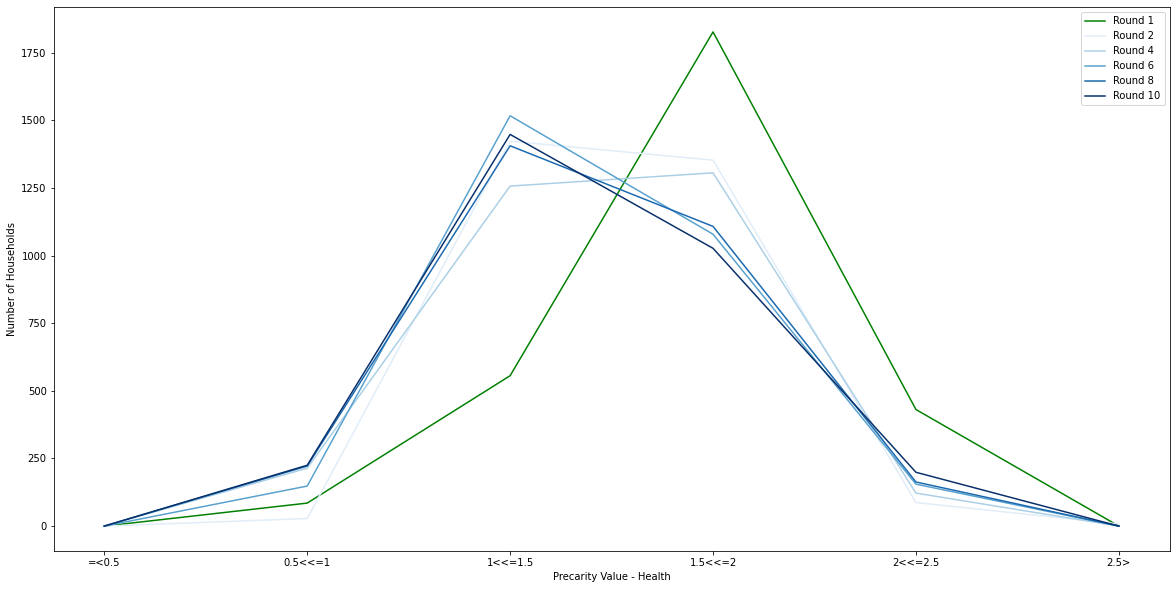

{'>=0.2': 0, '0.2<<=0.5': 0, '0.5<<=0.8': 261, '0.8<<=1.2': 497, '1.2<<=1.5': 977, '1.5<<=2.5': 1154, '2.5>': 10} 2899
{'>=0.2': 0, '0.2<<=0.5': 0, '0.5<<=0.8': 253, '0.8<<=1.2': 476, '1.2<<=1.5': 938, '1.5<<=2.5': 1225, '2.5>': 7} 2899
{'>=0.2': 0, '0.2<<=0.5': 0, '0.5<<=0.8': 206, '0.8<<=1.2': 467, '1.2<<=1.5': 914, '1.5<<=2.5': 1305, '2.5>': 7} 2899
{'>=0.2': 0, '0.2<<=0.5': 0, '0.5<<=0.8': 135, '0.8<<=1.2': 562, '1.2<<=1.5': 760, '1.5<<=2.5': 1440, '2.5>': 2} 2899
{'>=0.2': 0, '0.2<<=0.5': 0, '0.5<<=0.8': 85, '0.8<<=1.2': 547, '1.2<<=1.5': 871, '1.5<<=2.5': 1392, '2.5>': 4} 2899
{'>=0.2': 0, '0.2<<=0.5': 0, '0.5<<=0.8': 43, '0.8<<=1.2': 610, '1.2<<=1.5': 778, '1.5<<=2.5': 1464, '2.5>': 4} 2899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

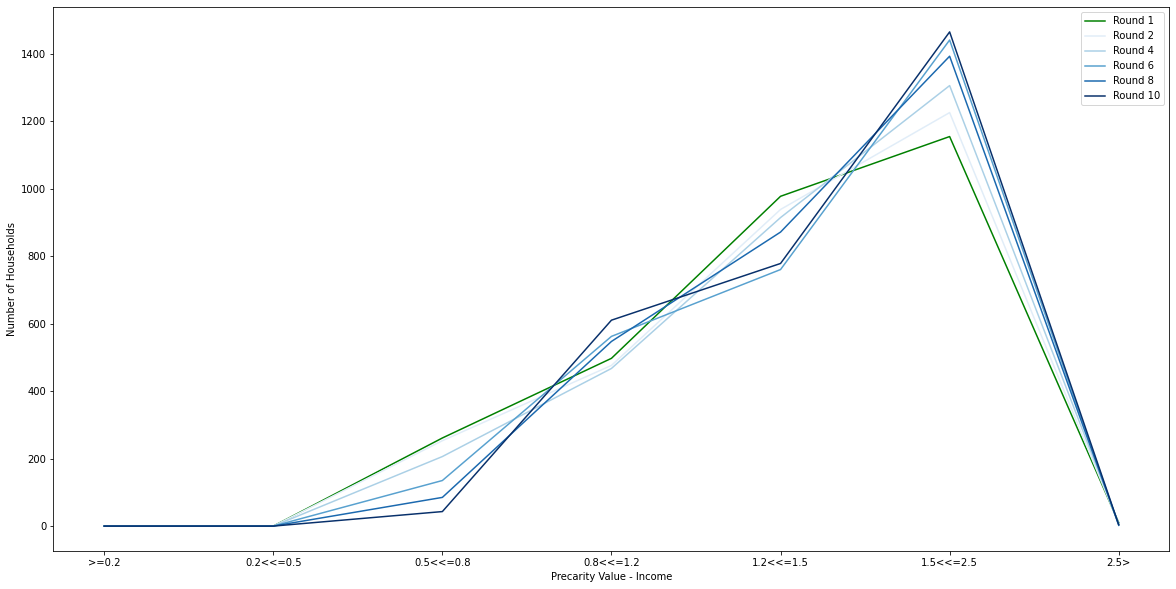

In [ ]:
#Low income group
np.random.seed(1234)
random.seed(1234)
T = iterations
P = 4
st = 0
m = len(low_level_people)
a_ = []
prec_ = []
prec_h = []
prec_s = []
c = np.arange(8, 18)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

for j in range(m):
  init_income = low_level_people[j]
  init_saving = get_savings(init_income)
  init_state = getState([init_saving])[0]
  st = getIncomeClass(init_income)
  a, z, h, inc = compute_asset_series_comp_health(ifp, a_star, σ_star, st,init_income, T=T, shock = P, init_a = init_saving)
  precarity = []#[0.2*(11-init_state)]
  h_st = getHealthStat(final_health_index(init_income))
  precarity_health = []#[0.2*(11-h_st)]
  
  inc_class = np.array([getIncomeClass(i) for i in inc])
  precarity_income = []#[0.2*(11-inc_class[0])]
  z = np.array(z)
  a_.append(a)
  h = np.array([getHealthStat(i) for i in h])
  for i in range(1,len(z)):
    weights_income =  generateWeight(inc_class[:i+1],values = [inc_10,inc_20,inc_30,inc_40,inc_50,inc_60,inc_70,inc_80,inc_90,inc_99,800000.00/12], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_income.append(precarityQuantification(inc_class[:i+1], [0,1,2,3,4,5,6,7,8,9,10], weights_income, 0.2, 1, 1.2, 11-h_st))
  prec_s.append(precarity_income)
  for i in range(1,len(h)):
    weights_health =  generateWeight_health(h[:i+1],values = [health_10,health_20,health_30,health_40,health_50,health_60,health_70,health_80,health_90,health_99,60], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_health.append(precarityQuantification(h[:i+1], [0,1,2,3,4,5,6,7,8,9, 10], weights_health, 0.2, 1, 1.2, 11-h_st))
  prec_h.append(precarity_health)
  for i in range(1,len(a)):
    weights_savings = generateWeight_savings(getState(a[:i+1]), values = savings_values, states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity.append(precarityQuantification(getState(a[:i+1]), [0,1,2,3,4,5,6,7,8,9, 10], weights_savings, 0.2, 1, 1.2, 11-init_state))
  prec_.append(precarity)
prec_ = np.array(prec_)
prec_h = np.array(prec_h)  
a_ = np.array(a_)
plt.figure(0, figsize=(20, 10))
Rounds = RoundsToDisplay 
for i in Rounds:
  bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 }
  y = list((plotter_distribution_networth_all(bucket_coarse, prec_[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Net Worth')
plt.savefig('ifp_precairty-low-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty-low-TransitionOriginal.png')
plt.legend()
plt.show()

plt.figure(1, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}
  y = list((plotter_distribution_health_all(bucket_coarse,prec_h[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Health')
plt.savefig('ifp_precairty_health-low-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_health-low-TransitionOriginal.png')
plt.legend()
plt.show()
prec_s = np.array(prec_s)

plt.figure(2, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }
  y = list((plotter_distribution_income_all(bucket_coarse,prec_s[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Income')
plt.savefig('ifp_precairty_income-low-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_income-low-TransitionOriginal.png')
plt.legend()
plt.show()

{'=<0.5': 0, '0.5<<=1': 1998, '1<<1.8': 3099, '>1.8': 102} 5199
{'=<0.5': 0, '0.5<<=1': 1907, '1<<1.8': 3292, '>1.8': 0} 5199
{'=<0.5': 0, '0.5<<=1': 1781, '1<<1.8': 3418, '>1.8': 0} 5199
{'=<0.5': 0, '0.5<<=1': 1674, '1<<1.8': 3525, '>1.8': 0} 5199
{'=<0.5': 0, '0.5<<=1': 1611, '1<<1.8': 3588, '>1.8': 0} 5199
{'=<0.5': 0, '0.5<<=1': 1567, '1<<1.8': 3632, '>1.8': 0} 5199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

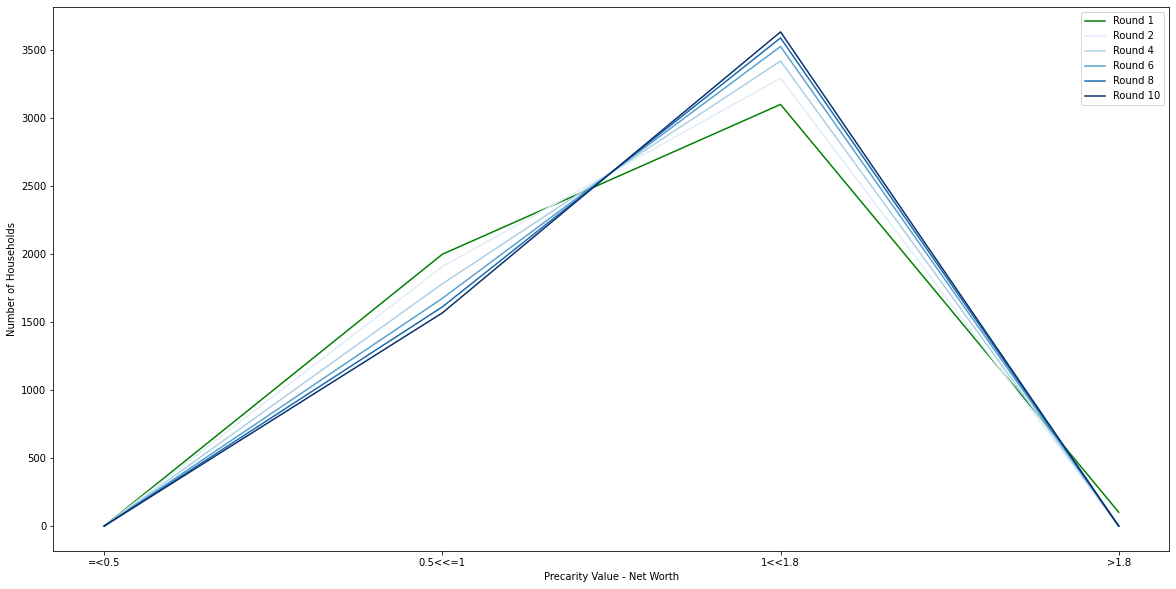

{'=<0.5': 315, '0.5<<=1': 364, '1<<=1.5': 1005, '1.5<<=2': 2894, '2<<=2.5': 621, '2.5>': 0} 5199
{'=<0.5': 132, '0.5<<=1': 1099, '1<<=1.5': 1800, '1.5<<=2': 1695, '2<<=2.5': 324, '2.5>': 149} 5199
{'=<0.5': 499, '0.5<<=1': 1243, '1<<=1.5': 1280, '1.5<<=2': 1576, '2<<=2.5': 577, '2.5>': 24} 5199
{'=<0.5': 462, '0.5<<=1': 1186, '1<<=1.5': 1618, '1.5<<=2': 1240, '2<<=2.5': 672, '2.5>': 21} 5199
{'=<0.5': 309, '0.5<<=1': 1578, '1<<=1.5': 1329, '1.5<<=2': 1228, '2<<=2.5': 745, '2.5>': 10} 5199
{'=<0.5': 522, '0.5<<=1': 1375, '1<<=1.5': 1365, '1.5<<=2': 1126, '2<<=2.5': 810, '2.5>': 1} 5199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

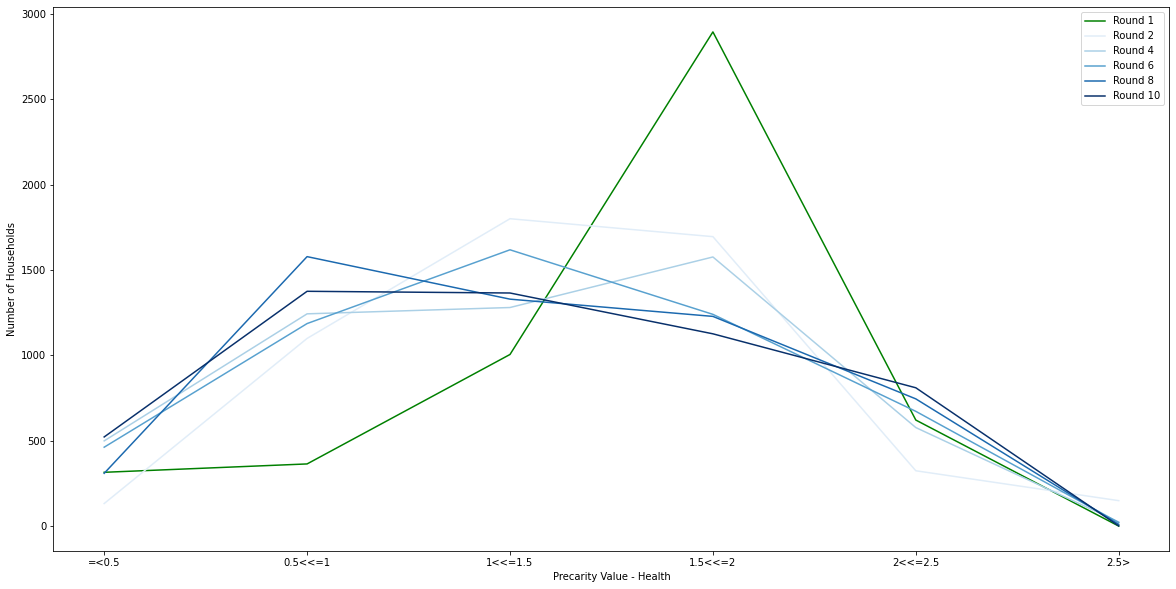

{'>=0.2': 0, '0.2<<=0.5': 746, '0.5<<=0.8': 959, '0.8<<=1.2': 346, '1.2<<=1.5': 695, '1.5<<=2.5': 1946, '2.5>': 507} 5199
{'>=0.2': 0, '0.2<<=0.5': 625, '0.5<<=0.8': 716, '0.8<<=1.2': 752, '1.2<<=1.5': 806, '1.5<<=2.5': 2081, '2.5>': 219} 5199
{'>=0.2': 0, '0.2<<=0.5': 383, '0.5<<=0.8': 861, '0.8<<=1.2': 903, '1.2<<=1.5': 730, '1.5<<=2.5': 2142, '2.5>': 180} 5199
{'>=0.2': 0, '0.2<<=0.5': 302, '0.5<<=0.8': 861, '0.8<<=1.2': 1009, '1.2<<=1.5': 714, '1.5<<=2.5': 2169, '2.5>': 144} 5199
{'>=0.2': 0, '0.2<<=0.5': 368, '0.5<<=0.8': 704, '0.8<<=1.2': 1110, '1.2<<=1.5': 712, '1.5<<=2.5': 2164, '2.5>': 141} 5199
{'>=0.2': 0, '0.2<<=0.5': 237, '0.5<<=0.8': 794, '0.8<<=1.2': 1149, '1.2<<=1.5': 687, '1.5<<=2.5': 2224, '2.5>': 108} 5199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

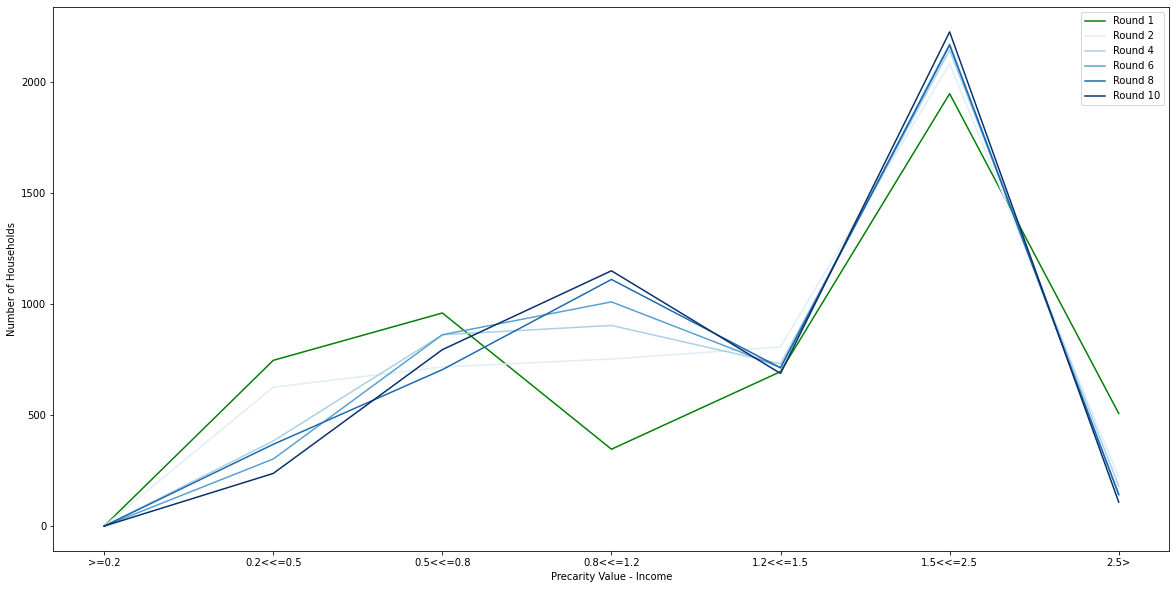

In [ ]:
#Middle income group
np.random.seed(1234)
random.seed(1234)
T = iterations
P = 4
st = 0
m = len(mid_level_people)
a_ = []
prec_ = []
prec_h = []
prec_s = []
c = np.arange(8, 18)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
t = [2,3,4,5,6]
for j in range(m):
  init_income = mid_level_people[j]
  init_saving = get_savings(init_income)
  init_state = getState([init_saving])[0]
  st = getIncomeClass(init_income)
  a, z, h, inc = compute_asset_series_comp_health(ifp, a_star, σ_star, st,init_income, T=T, shock = P, init_a = init_saving)
  precarity = []#[0.2*(11-init_state)]
  h_st = getHealthStat(final_health_index(init_income))
  precarity_health = []#[0.2*(11-h_st)]
  inc_class = np.array([getIncomeClass(i) for i in inc])
  precarity_income = []#[0.2*(11-inc_class[0])]
  z = np.array(z)
  a_.append(a)
  h = np.array([getHealthStat(i) for i in h])
  for i in range(1,len(z)):
    weights_income =  generateWeight(inc_class[:i+1],values = [inc_10,inc_20,inc_30,inc_40,inc_50,inc_60,inc_70,inc_80,inc_90,inc_99,800000.00/12], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_income.append(precarityQuantification(inc_class[:i+1], [0,1,2,3,4,5,6,7,8,9,10], weights_income, 0.2, 1, 1.2, 11-h_st))
  prec_s.append(precarity_income)
  for i in range(1,len(h)):
    weights_health =  generateWeight_health(h[:i+1],values = [health_10,health_20,health_30,health_40,health_50,health_60,health_70,health_80,health_90,health_99,60], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_health.append(precarityQuantification(h[:i+1], [0,1,2,3,4,5,6,7,8,9, 10], weights_health, 0.2, 1, 1.2, 11-h_st))
  prec_h.append(precarity_health)
  for i in range(1,len(a)):
    weights_savings = generateWeight_savings(getState(a[:i+1]), values = savings_values, states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity.append(precarityQuantification(getState(a[:i+1]), [0,1,2,3,4,5,6,7,8,9, 10], weights_savings, 0.2, 1, 1.2, 11-init_state))
  prec_.append(precarity)
prec_ = np.array(prec_)
prec_h = np.array(prec_h)  
a_ = np.array(a_)
plt.figure(0, figsize=(20, 10))
Rounds =RoundsToDisplay 
for i in Rounds:
  bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 }
  y = list((plotter_distribution_networth_all(bucket_coarse,prec_[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Net Worth')
plt.savefig('ifp_precairty-middle-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty-middle-TransitionOriginal.png')
plt.legend()
plt.show()

plt.figure(1, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}
  y = list((plotter_distribution_health_all(bucket_coarse,prec_h[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Health')
plt.savefig('ifp_precairty_health-middle-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_health-middle-TransitionOriginal.png')
plt.legend()
plt.show()

prec_s = np.array(prec_s)
plt.figure(2, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }
  y = list((plotter_distribution_income_all(bucket_coarse,prec_s[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Income')
plt.savefig('ifp_precairty_income-middle-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_income-middle-TransitionOriginal.png')
plt.legend()
plt.show()

{'=<0.5': 1000, '0.5<<=1': 899, '1<<1.8': 0, '>1.8': 0} 1899
{'=<0.5': 1000, '0.5<<=1': 899, '1<<1.8': 0, '>1.8': 0} 1899
{'=<0.5': 1000, '0.5<<=1': 899, '1<<1.8': 0, '>1.8': 0} 1899
{'=<0.5': 1000, '0.5<<=1': 899, '1<<1.8': 0, '>1.8': 0} 1899
{'=<0.5': 1000, '0.5<<=1': 899, '1<<1.8': 0, '>1.8': 0} 1899
{'=<0.5': 1000, '0.5<<=1': 899, '1<<1.8': 0, '>1.8': 0} 1899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

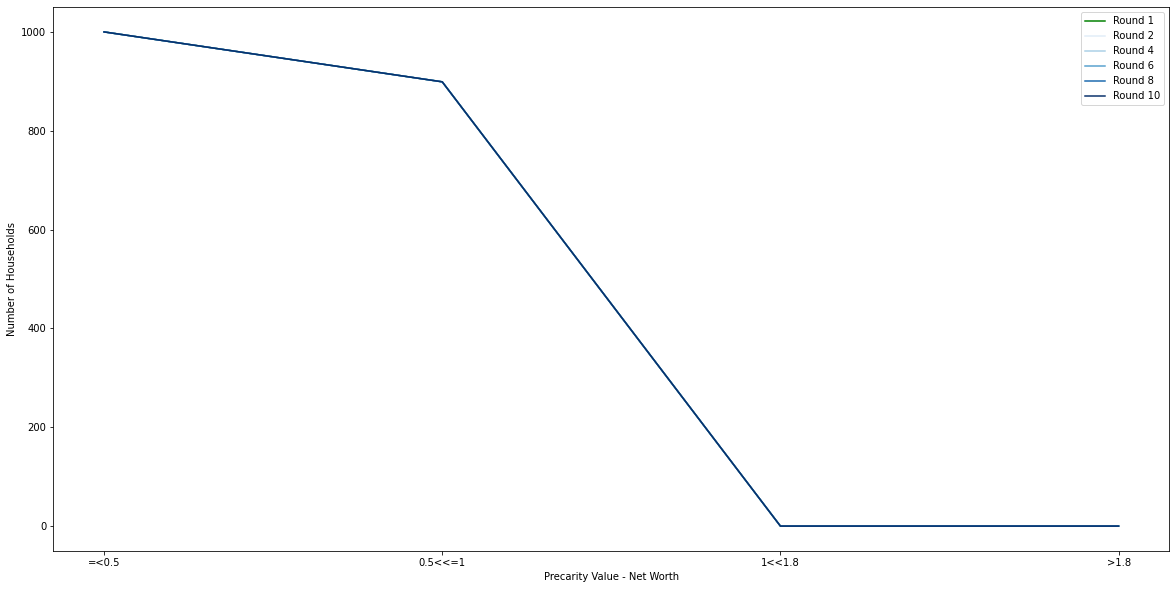

{'=<0.5': 13, '0.5<<=1': 94, '1<<=1.5': 272, '1.5<<=2': 733, '2<<=2.5': 787, '2.5>': 0} 1899
{'=<0.5': 83, '0.5<<=1': 457, '1<<=1.5': 287, '1.5<<=2': 280, '2<<=2.5': 653, '2.5>': 139} 1899
{'=<0.5': 152, '0.5<<=1': 495, '1<<=1.5': 184, '1.5<<=2': 254, '2<<=2.5': 799, '2.5>': 15} 1899
{'=<0.5': 165, '0.5<<=1': 506, '1<<=1.5': 196, '1.5<<=2': 195, '2<<=2.5': 816, '2.5>': 21} 1899
{'=<0.5': 142, '0.5<<=1': 566, '1<<=1.5': 153, '1.5<<=2': 188, '2<<=2.5': 843, '2.5>': 7} 1899
{'=<0.5': 185, '0.5<<=1': 526, '1<<=1.5': 154, '1.5<<=2': 169, '2<<=2.5': 862, '2.5>': 3} 1899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

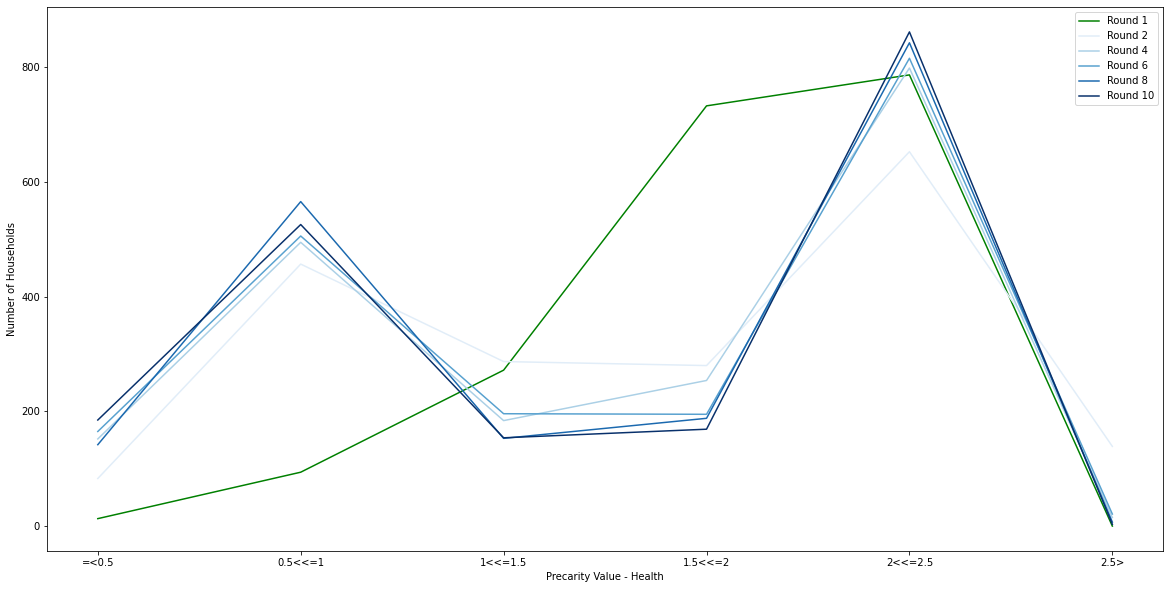

{'>=0.2': 53, '0.2<<=0.5': 80, '0.5<<=0.8': 323, '0.8<<=1.2': 80, '1.2<<=1.5': 110, '1.5<<=2.5': 863, '2.5>': 390} 1899
{'>=0.2': 33, '0.2<<=0.5': 84, '0.5<<=0.8': 260, '0.8<<=1.2': 269, '1.2<<=1.5': 95, '1.5<<=2.5': 909, '2.5>': 249} 1899
{'>=0.2': 11, '0.2<<=0.5': 77, '0.5<<=0.8': 337, '0.8<<=1.2': 257, '1.2<<=1.5': 110, '1.5<<=2.5': 753, '2.5>': 354} 1899
{'>=0.2': 3, '0.2<<=0.5': 90, '0.5<<=0.8': 267, '0.8<<=1.2': 339, '1.2<<=1.5': 104, '1.5<<=2.5': 811, '2.5>': 285} 1899
{'>=0.2': 1, '0.2<<=0.5': 87, '0.5<<=0.8': 309, '0.8<<=1.2': 312, '1.2<<=1.5': 102, '1.5<<=2.5': 796, '2.5>': 292} 1899
{'>=0.2': 0, '0.2<<=0.5': 86, '0.5<<=0.8': 266, '0.8<<=1.2': 367, '1.2<<=1.5': 96, '1.5<<=2.5': 819, '2.5>': 265} 1899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

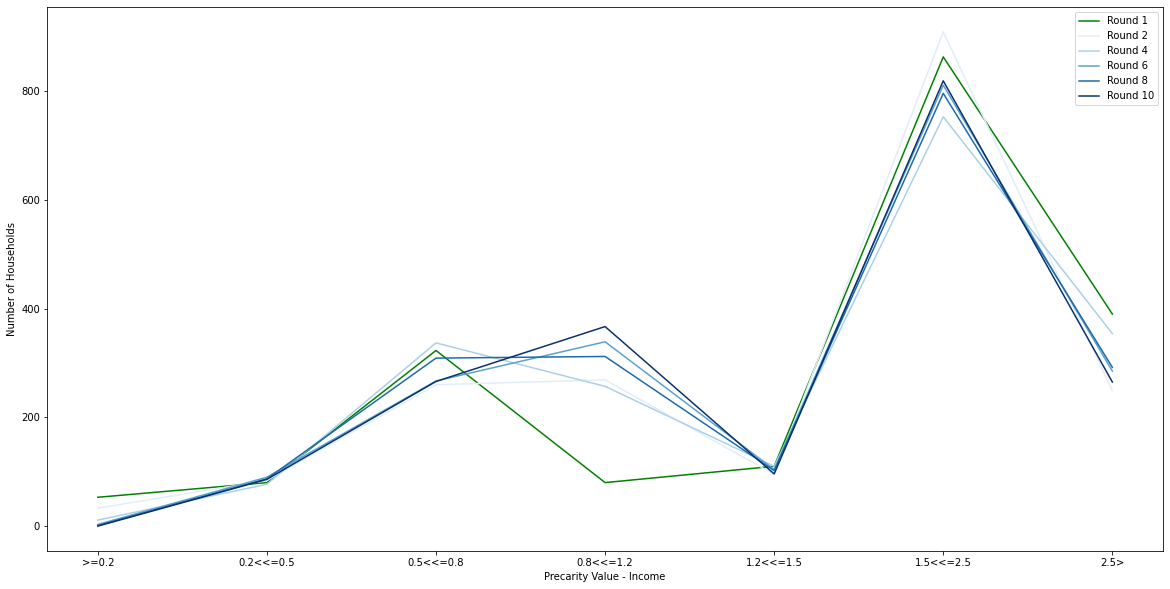

In [ ]:
#High income group
np.random.seed(1234)
random.seed(1234)
T = iterations
P = 4
st = 0
m = len(hih_level_people)
a_ = []
prec_ = []
prec_h = []
prec_s = []
c = np.arange(8, 18)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
t = [7,8,9]
for j in range(m):
  init_income = hih_level_people[j]
  init_saving = get_savings(init_income)
  init_state = getState([init_saving])[0]
  st = getIncomeClass(init_income)
  a, z, h, inc = compute_asset_series_comp_health(ifp, a_star, σ_star, st, init_income, T=T, shock = P, init_a = init_saving)
  precarity = []#[0.2*(11-init_state)]
  h_st = getHealthStat(final_health_index(init_income))
  precarity_health = []#[0.2*(11-h_st)]
  inc_class = np.array([getIncomeClass(i) for i in inc])
  precarity_income = []#[0.2*(11-inc_class[0])]
  z = np.array(z)
  a_.append(a)
  h = np.array([getHealthStat(i) for i in h])
  for i in range(1,len(z)):
    weights_income =  generateWeight(inc_class[:i+1],values = [inc_10,inc_20,inc_30,inc_40,inc_50,inc_60,inc_70,inc_80,inc_90,inc_99,800000.00/12], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_income.append(precarityQuantification(inc_class[:i+1], [0,1,2,3,4,5,6,7,8,9,10], weights_income, 0.2, 1, 1.2, 11-h_st))
  prec_s.append(precarity_income)
  for i in range(1,len(h)):
    weights_health =  generateWeight_health(h[:i+1],values = [health_10,health_20,health_30,health_40,health_50,health_60,health_70,health_80,health_90,health_99,60], states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity_health.append(precarityQuantification(h[:i+1], [0,1,2,3,4,5,6,7,8,9, 10], weights_health, 0.2, 1, 1.2, 11-h_st))
  prec_h.append(precarity_health)
  for i in range(1,len(a)):
    weights_savings = generateWeight_savings(getState(a[:i+1]), values = savings_values, states = [0, 1, 2, 3, 4, 5, 6,7,8,9, 10])
    precarity.append(precarityQuantification(getState(a[:i+1]), [0,1,2,3,4,5,6,7,8,9, 10], weights_savings, 0.2, 1, 1.2, 11-init_state))
  prec_.append(precarity)
prec_ = np.array(prec_)
prec_h = np.array(prec_h)  
a_ = np.array(a_)
plt.figure(0, figsize=(20, 10))
Rounds =RoundsToDisplay #[0,1,3,5,7,9]
for i in Rounds:
  bucket_coarse = {'=<0.5': 0, '0.5<<=1' : 0,  '1<<1.8' : 0, '>1.8':0 }
  y = list((plotter_distribution_networth_all(bucket_coarse,prec_[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Net Worth')
plt.savefig('ifp_precairty-high-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty-high-TransitionOriginal.png')
plt.legend()
plt.show()

plt.figure(1, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'=<0.5': 0,'0.5<<=1':0,  '1<<=1.5':0 ,'1.5<<=2':0, '2<<=2.5':0, '2.5>':0}
  y = list((plotter_distribution_health_all(bucket_coarse,prec_h[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Health')
plt.savefig('ifp_precairty_health-high-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_health-high-TransitionOriginal.png')
plt.legend()
plt.show()

prec_s = np.array(prec_s)
plt.figure(2, figsize=(20, 10))
for i in Rounds:
  bucket_coarse = {'>=0.2': 0,'0.2<<=0.5':0, '0.5<<=0.8' : 0, '0.8<<=1.2' : 0, '1.2<<=1.5' : 0, '1.5<<=2.5' : 0, '2.5>':0 }
  y = list((plotter_distribution_income_all(bucket_coarse,prec_s[:,i], 1)).values())
  print(bucket_coarse, sum(bucket_coarse.values()))
  if (i==0):
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c='g',markevery=1)#,width=0.4, align='edge')
  else:
    plt.plot(list(bucket_coarse.keys()),y,label='Round '+str(i+1),c=cmap.to_rgba(c[ColorCodes[Rounds.index(i)]]),markevery=1)#,width=0.4, align='edge')
    # print (bucket_coarse.values())
  plt.xticks(rotation='horizontal')
  plt.locator_params(axis='x',numticks = 4)
  plt.legend(loc=2, prop={'size': 14})
  plt.ylabel('Number of Households')
  plt.xlabel('Precarity Value - Income')
plt.savefig('ifp_precairty_income-high-TransitionOriginal.png',bbox_inches='tight')
files.download('ifp_precairty_income-high-TransitionOriginal.png')
plt.legend()
plt.show()